In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data Analysis

## Read Data

In [ ]:
# След като приготвихме комбинирания сет с данни ще го анализираме

In [3]:
df_data = pd.read_csv(r"output_data_sets/combined_dataset.csv", sep=',')
df_data

time  generation biomass  \
0      2014-12-31 23:00:00+00:00               447.0   
1      2015-01-01 00:00:00+00:00               449.0   
2      2015-01-01 01:00:00+00:00               448.0   
3      2015-01-01 02:00:00+00:00               438.0   
4      2015-01-01 03:00:00+00:00               428.0   
...                          ...                 ...   
35059  2018-12-31 18:00:00+00:00               297.0   
35060  2018-12-31 19:00:00+00:00               296.0   
35061  2018-12-31 20:00:00+00:00               292.0   
35062  2018-12-31 21:00:00+00:00               293.0   
35063  2018-12-31 22:00:00+00:00               290.0   

       generation fossil brown coal/lignite  generation fossil gas  \
0                                     329.0                 4844.0   
1                                     328.0                 5196.0   
2                                     323.0                 4857.0   
3                                     254.0                 4314.0   
4                                     187.0                 4130.0   
...                                     ...                    ...   
35059                                   0.0                 7634.0   
35060                                   0.0                 7241.0   
35061                                   0.0                 7025.0   
35062                                   0.0                 6562.0   
35063                                   0.0                 6926.0   

       generation fossil hard coal  generation fossil oil  \
0                           4821.0                  162.0   
1                           4755.0                  158.0   
2                           4581.0                  157.0   
3                           4131.0                  160.0   
4                           3840.0                  156.0   
...                            ...                    ...   
35059                       2628.0                  178.0   
35060                       2566.0                  174.0   
35061                       2422.0                  168.0   
35062                       2293.0                  163.0   
35063                       2166.0                  163.0   

       generation hydro pumped storage consumption  \
0                                            863.0   
1                                            920.0   
2                                           1164.0   
3                                           1503.0   
4                                           1826.0   
...                                            ...   
35059                                          1.0   
35060                                          1.0   
35061                                         50.0   
35062                                        108.0   
35063                                        108.0   

       generation hydro run-of-river and poundage  \
0                                          1051.0   
1                                          1009.0   
2                                           973.0   
3                                           949.0   
4                                           953.0   
...                                           ...   
35059                                      1135.0   
35060                                      1172.0   
35061                                      1148.0   
35062                                      1128.0   
35063                                      1069.0   

       generation hydro water reservoir  generation nuclear  ...  \
0                                1899.0              7096.0  ...   
1                                1658.0              7096.0  ...   
2                                1371.0              7099.0  ...   
3                                 779.0              7098.0  ...   
4                                 720.0              7097.0  ...   
...                                 ...                 ...  ...   
35059              

In [4]:
df_data.index.names = ['index']
df_data['time'] = pd.to_datetime(df_data['time'], utc=True, infer_datetime_format=True)
df_data = df_data.set_index('time')

In [5]:
list(df_data.columns)

['generation biomass',
 'generation fossil brown coal/lignite',
 'generation fossil gas',
 'generation fossil hard coal',
 'generation fossil oil',
 'generation hydro pumped storage consumption',
 'generation hydro run-of-river and poundage',
 'generation hydro water reservoir',
 'generation nuclear',
 'generation other',
 'generation other renewable',
 'generation solar',
 'generation waste',
 'generation wind onshore',
 'forecast solar day ahead',
 'forecast wind onshore day ahead',
 'total load forecast',
 'total load actual',
 'price day ahead',
 'price actual',
 'temp_Barcelona',
 'temp_min_Barcelona',
 'temp_max_Barcelona',
 'pressure_Barcelona',
 'humidity_Barcelona',
 'wind_speed_Barcelona',
 'wind_deg_Barcelona',
 'rain_1h_Barcelona',
 'snow_3h_Barcelona',
 'clouds_all_Barcelona',
 'weather_main_clear_Barcelona',
 'weather_main_clouds_Barcelona',
 'weather_main_drizzle_Barcelona',
 'weather_main_dust_Barcelona',
 'weather_main_fog_Barcelona',
 'weather_main_haze_Barcelona',
 '

In [6]:
# Премахваме колоните с данни от съществуващата до този момент оценка. По къдно ще изчислим от тях доколко съществуващият модел се е справял с прогнозата.
df_data = df_data.drop(['forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'price day ahead'], axis = 1)
list(df_data.columns)

['generation biomass',
 'generation fossil brown coal/lignite',
 'generation fossil gas',
 'generation fossil hard coal',
 'generation fossil oil',
 'generation hydro pumped storage consumption',
 'generation hydro run-of-river and poundage',
 'generation hydro water reservoir',
 'generation nuclear',
 'generation other',
 'generation other renewable',
 'generation solar',
 'generation waste',
 'generation wind onshore',
 'total load actual',
 'price actual',
 'temp_Barcelona',
 'temp_min_Barcelona',
 'temp_max_Barcelona',
 'pressure_Barcelona',
 'humidity_Barcelona',
 'wind_speed_Barcelona',
 'wind_deg_Barcelona',
 'rain_1h_Barcelona',
 'snow_3h_Barcelona',
 'clouds_all_Barcelona',
 'weather_main_clear_Barcelona',
 'weather_main_clouds_Barcelona',
 'weather_main_drizzle_Barcelona',
 'weather_main_dust_Barcelona',
 'weather_main_fog_Barcelona',
 'weather_main_haze_Barcelona',
 'weather_main_mist_Barcelona',
 'weather_main_rain_Barcelona',
 'weather_main_smoke_Barcelona',
 'weather_main

## Core Function

In [3]:
def prepare_windows(df, window_size, col_name):
    sample = []
    ts_dataset = pd.DataFrame()
    for i in range(1, window_size+1):
        ts_dataset[f"Lag_{i}"] = df[col_name].shift(i) 
    ts_dataset =  pd.concat([df, ts_dataset], axis=1)
    return ts_dataset.loc[window_size:, :]

In [8]:
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

<ipython-input-8-8dd8e79e1662>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plot_series(df=None, column=None, series=pd.Series([]),


## Electricity Price Analysis

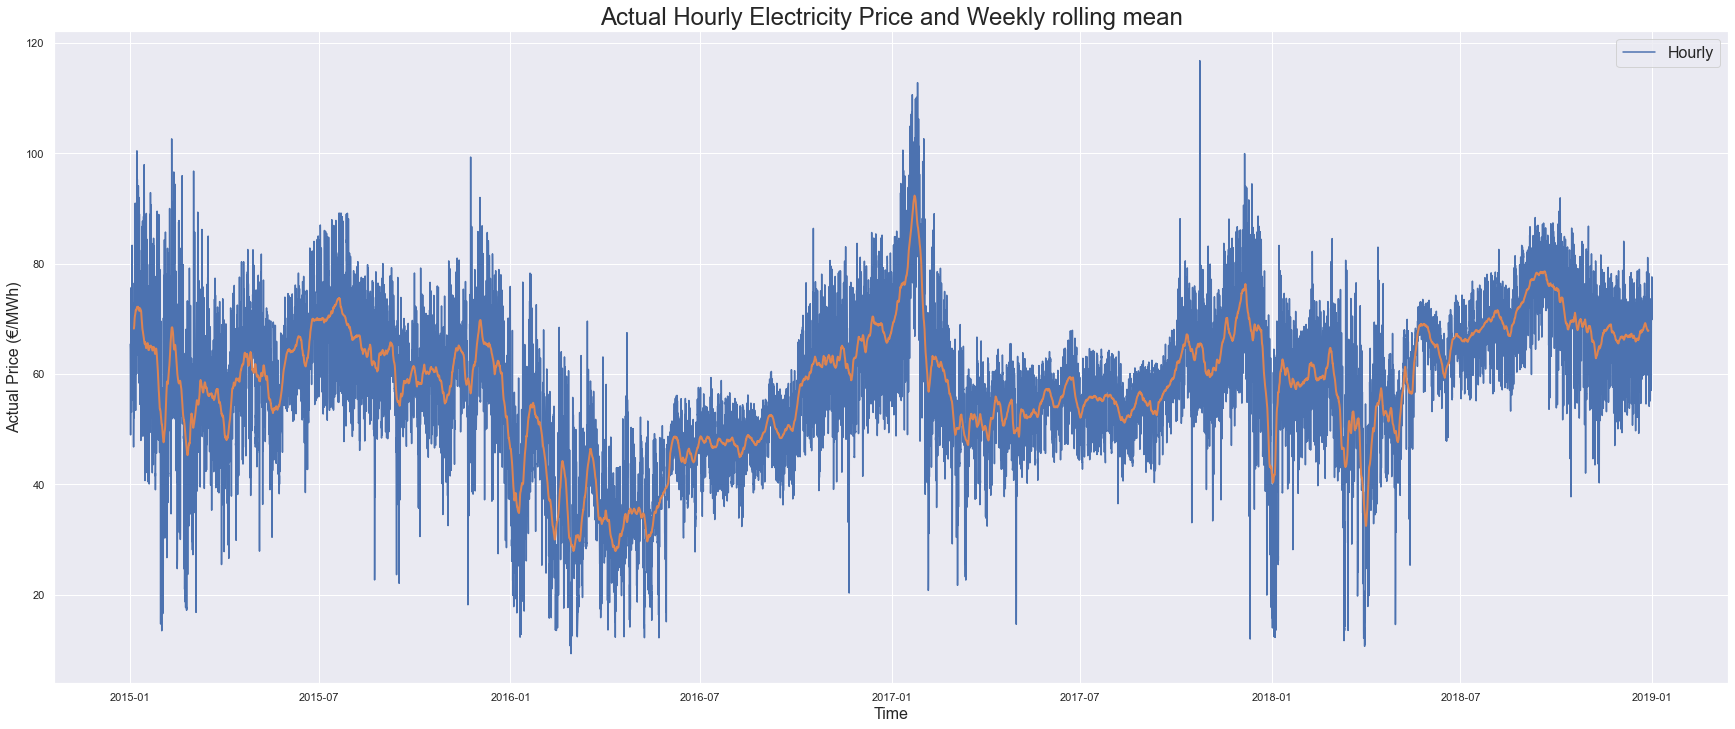

In [9]:
# Plot the hourly actual electricity price, along with the weekly rolling mean
rolling = df_data['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_data, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')

plt.show()

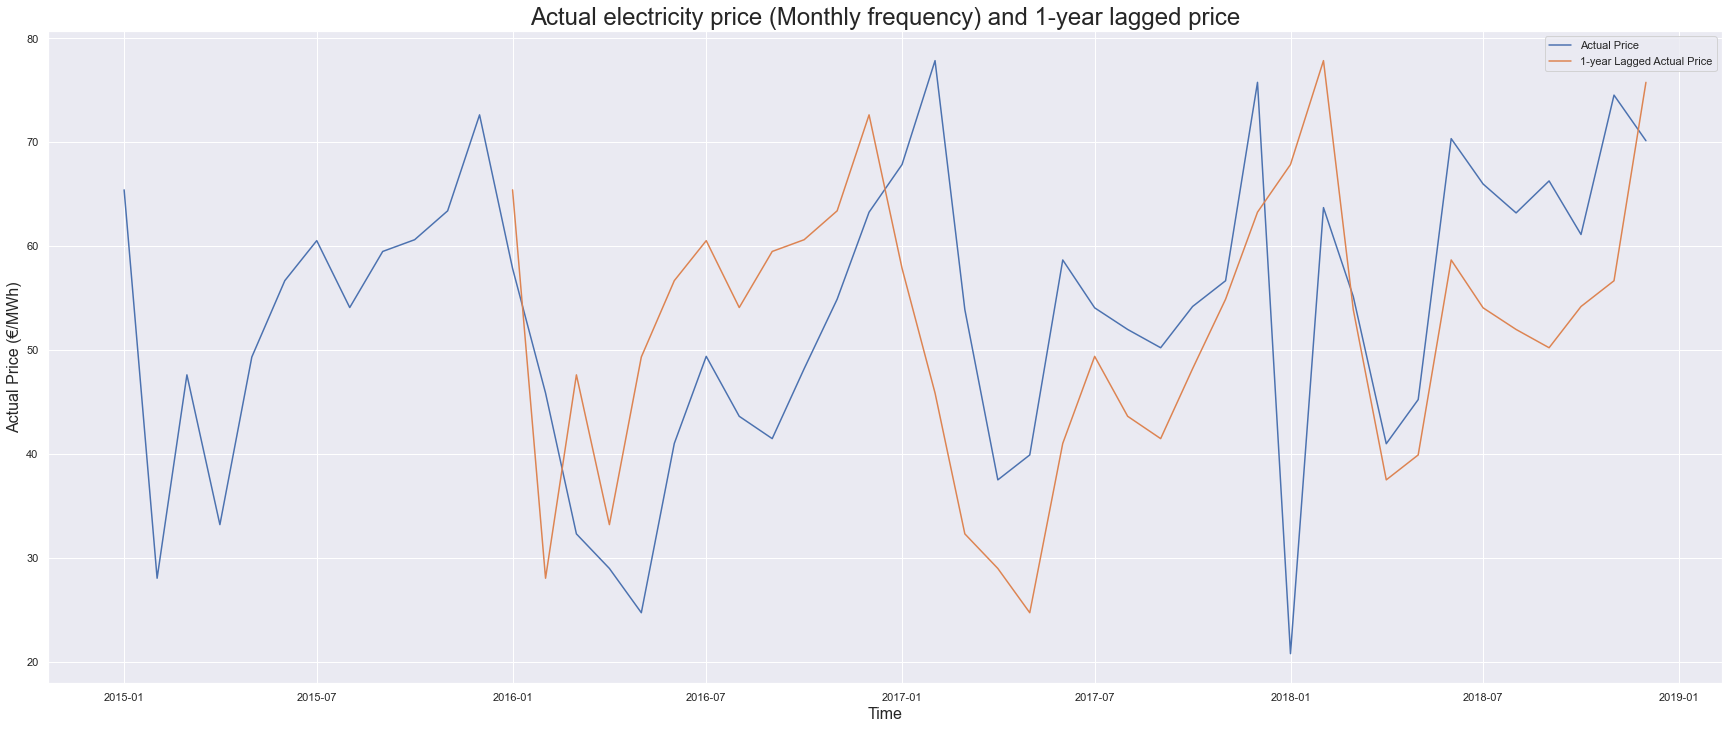

In [10]:
# Plot the electricity price (monthly frequence) along with its 1-year lagged series
monthly_price = df_data['price actual'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual electricity price (Monthly frequency) and 1-year lagged price')
shifted = df_data['price actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()

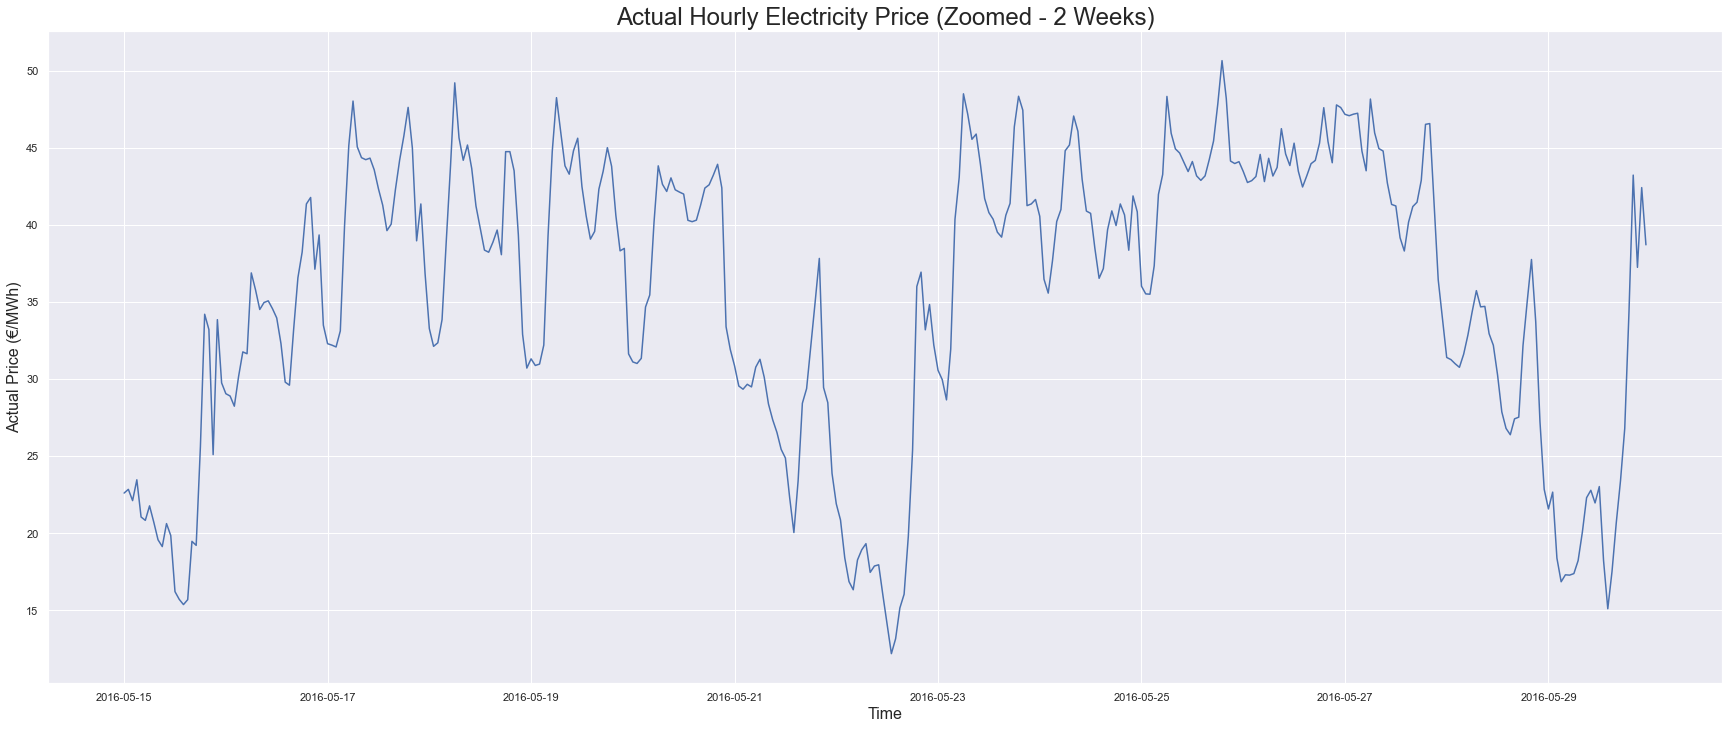

In [11]:
# Plot the actual electricity price at a daily/weekly scale
ax = plot_series(df_data, 'price actual', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()

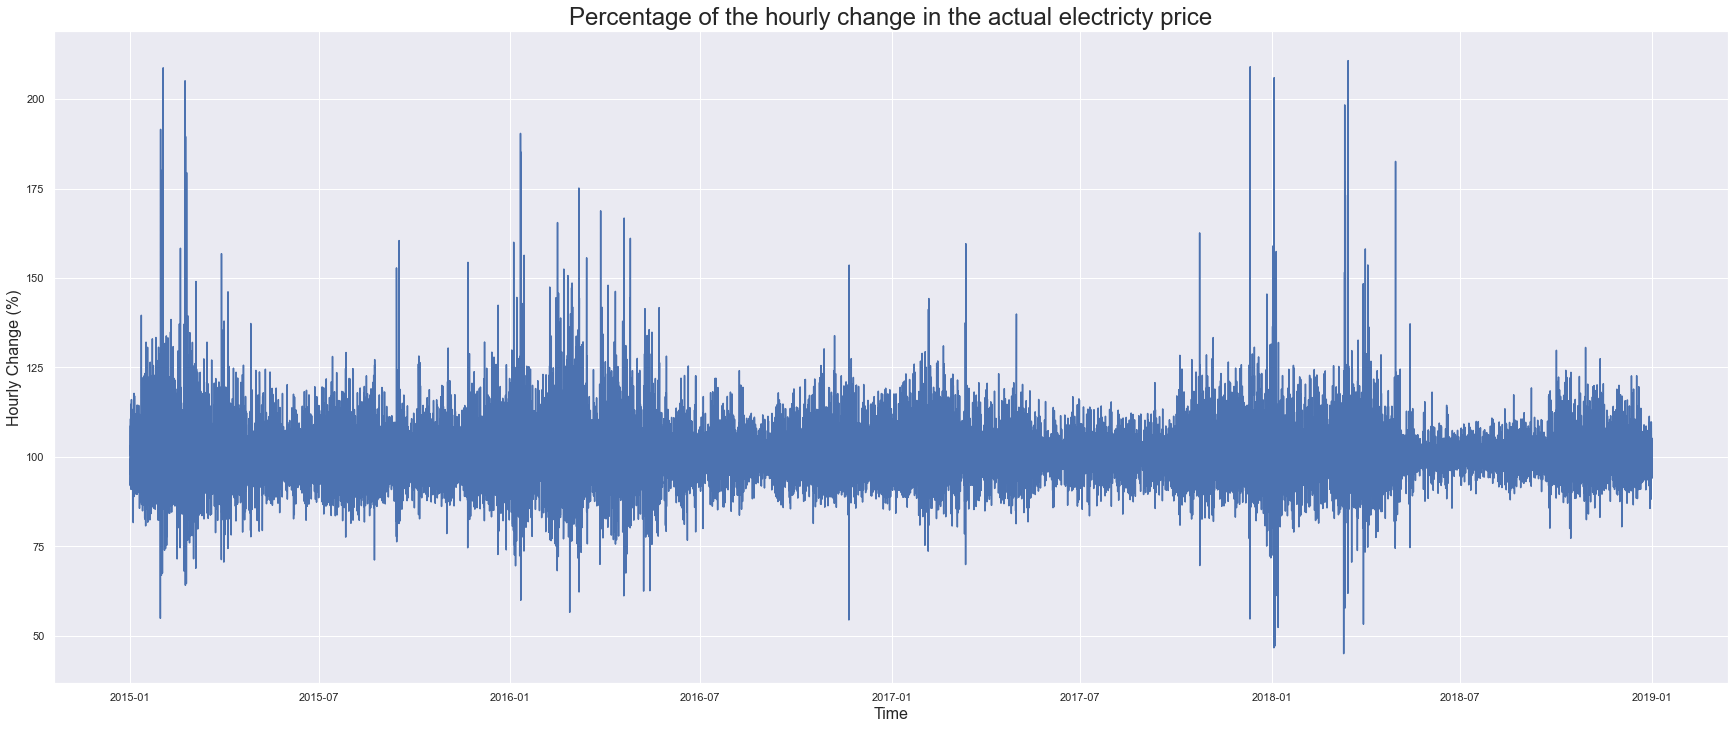

In [12]:
# Plot the percentage of the hourly change in the actual electricity price

change = df_data['price actual'].div(df_data['price actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change in the actual electricty price')
plt.show()

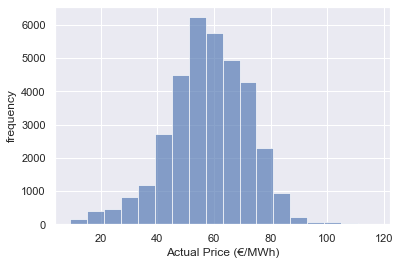

In [13]:
ax = df_data['price actual'].plot.hist(bins=18, alpha=0.65)
plt.xlabel('Actual Price (€/MWh)')
plt.ylabel('frequency')
plt.show()

In [20]:
df_data[df_data.index.to_series().diff() > "1 hour"]

Empty DataFrame
Columns: [generation biomass, generation fossil brown coal/lignite, generation fossil gas, generation fossil hard coal, generation fossil oil, generation hydro pumped storage consumption, generation hydro run-of-river and poundage, generation hydro water reservoir, generation nuclear, generation other, generation other renewable, generation solar, generation waste, generation wind onshore, total load actual, price actual, temp_Barcelona, temp_min_Barcelona, temp_max_Barcelona, pressure_Barcelona, humidity_Barcelona, wind_speed_Barcelona, wind_deg_Barcelona, rain_1h_Barcelona, snow_3h_Barcelona, clouds_all_Barcelona, weather_main_clear_Barcelona, weather_main_clouds_Barcelona, weather_main_drizzle_Barcelona, weather_main_dust_Barcelona, weather_main_fog_Barcelona, weather_main_haze_Barcelona, weather_main_mist_Barcelona, weather_main_rain_Barcelona, weather_main_smoke_Barcelona, weather_main_snow_Barcelona, weather_main_squall_Barcelona, weather_main_thunderstorm_Barcelona, temp_Bilbao, temp_min_Bilbao, temp_max_Bilbao, pressure_Bilbao, humidity_Bilbao, wind_speed_Bilbao, wind_deg_Bilbao, rain_1h_Bilbao, snow_3h_Bilbao, clouds_all_Bilbao, weather_main_clear_Bilbao, weather_main_clouds_Bilbao, weather_main_drizzle_Bilbao, weather_main_dust_Bilbao, weather_main_fog_Bilbao, weather_main_haze_Bilbao, weather_main_mist_Bilbao, weather_main_rain_Bilbao, weather_main_smoke_Bilbao, weather_main_snow_Bilbao, weather_main_squall_Bilbao, weather_main_thunderstorm_Bilbao, temp_Madrid, temp_min_Madrid, temp_max_Madrid, pressure_Madrid, humidity_Madrid, wind_speed_Madrid, wind_deg_Madrid, rain_1h_Madrid, snow_3h_Madrid, clouds_all_Madrid, weather_main_clear_Madrid, weather_main_clouds_Madrid, weather_main_drizzle_Madrid, weather_main_dust_Madrid, weather_main_fog_Madrid, weather_main_haze_Madrid, weather_main_mist_Madrid, weather_main_rain_Madrid, weather_main_smoke_Madrid, weather_main_snow_Madrid, weather_main_squall_Madrid, weather_main_thunderstorm_Madrid, temp_Seville, temp_min_Seville, temp_max_Seville, pressure_Seville, humidity_Seville, wind_speed_Seville, wind_deg_Seville, rain_1h_Seville, snow_3h_Seville, clouds_all_Seville, weather_main_clear_Seville, weather_main_clouds_Seville, weather_main_drizzle_Seville, weather_main_dust_Seville, weather_main_fog_Seville, weather_main_haze_Seville, weather_main_mist_Seville, weather_main_rain_Seville, ...]
Index: []

[0 rows x 126 columns]

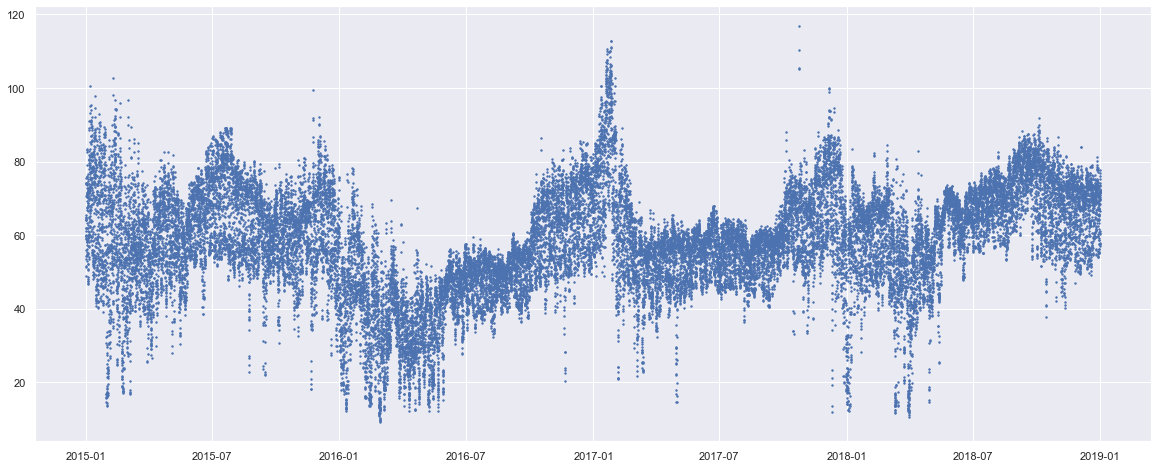

In [21]:
plt.figure(figsize=(20,8))
plt.scatter(df_data.index, df_data['price actual'], s = 2)
plt.show()

In [22]:
df_last = set(df_data[df_data.index > '2018-12-18'].index.date)
df_last


{datetime.date(2018, 12, 18),
 datetime.date(2018, 12, 19),
 datetime.date(2018, 12, 20),
 datetime.date(2018, 12, 21),
 datetime.date(2018, 12, 22),
 datetime.date(2018, 12, 23),
 datetime.date(2018, 12, 24),
 datetime.date(2018, 12, 25),
 datetime.date(2018, 12, 26),
 datetime.date(2018, 12, 27),
 datetime.date(2018, 12, 28),
 datetime.date(2018, 12, 29),
 datetime.date(2018, 12, 30),
 datetime.date(2018, 12, 31)}

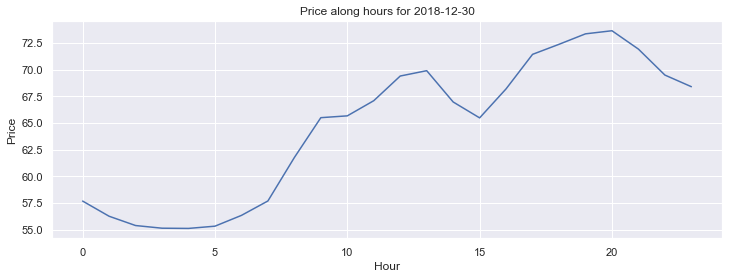

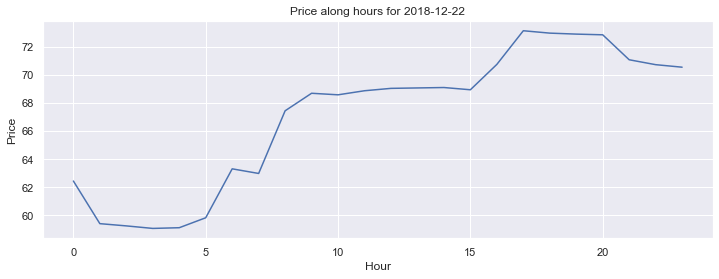

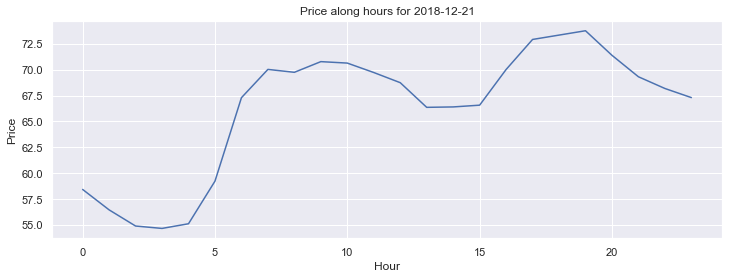

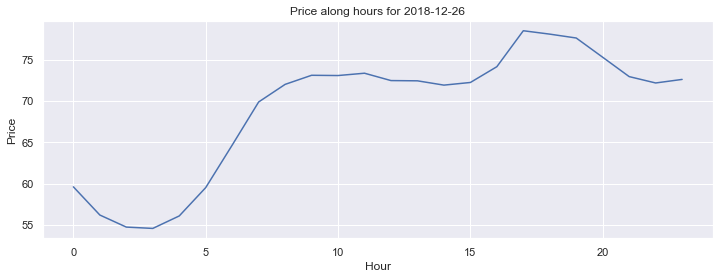

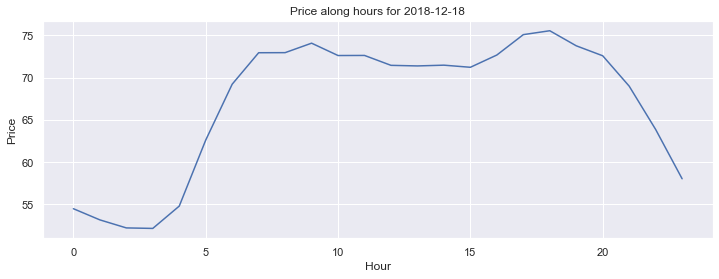

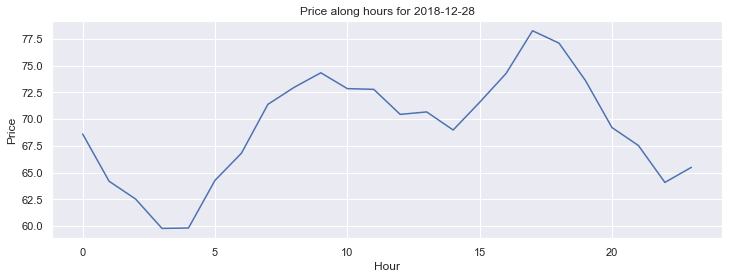

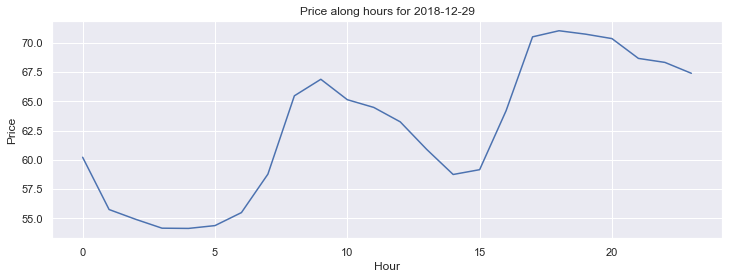

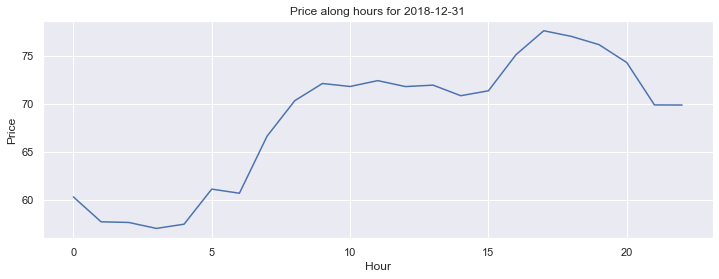

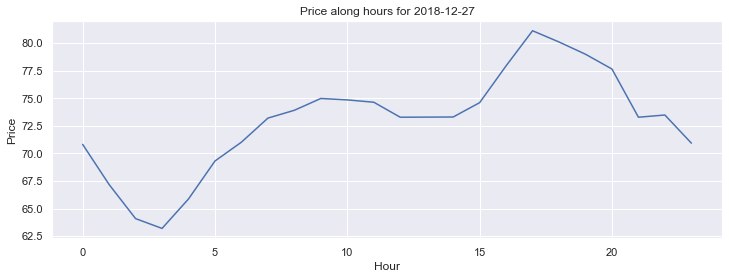

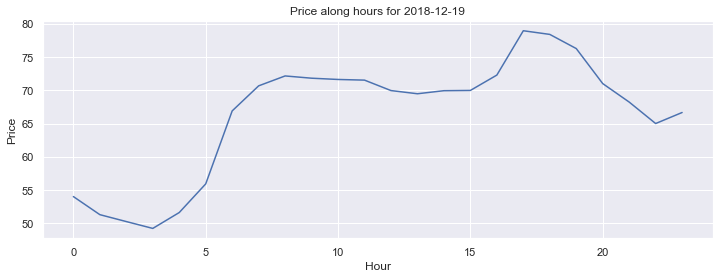

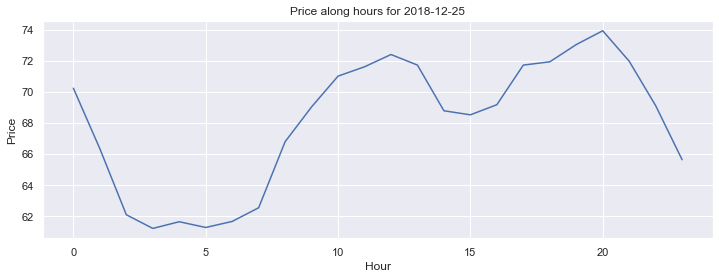

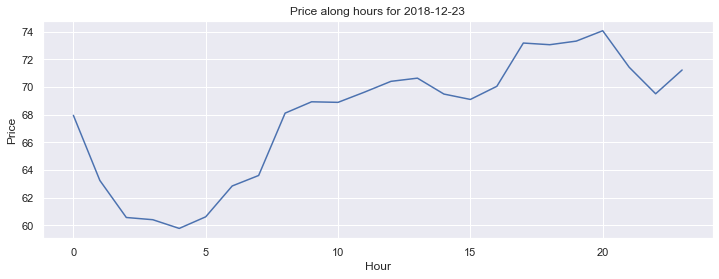

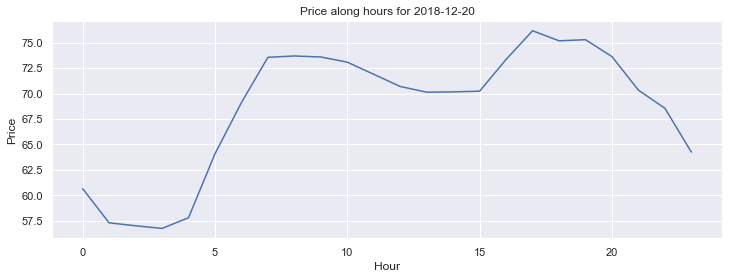

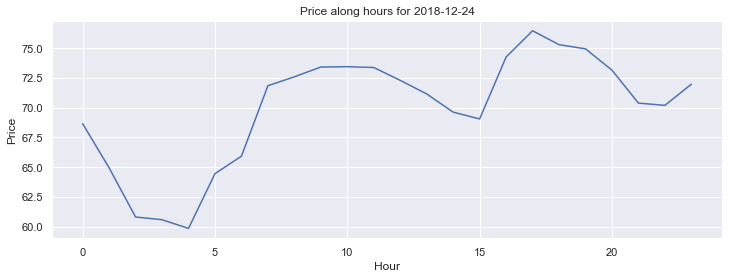

In [23]:
for date in df_last:
    plt.figure(figsize=(12,4))
    day_meas =  df_data[df_data.index.date == date]
    plt.plot(day_meas.index.hour, day_meas['price actual'])
    plt.title(f"Price along hours for {date}" )
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.show()

In [24]:
# https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html -запълване на липсващите данни - ако периода е по-голям от един час примерно
# https://dynamictimewarping.github.io/python/ dtw-python: Dynamic Time Warping in Python
# adf test for stacionarity    https://www.google.com/search?client=firefox-b-d&q=adf+test+for+stacionarity
# https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [25]:
df_data["date"] = df_data.index.date

In [26]:
price_actual_means_daily = df_data.groupby("date")["price actual"].mean()
price_actual_means_daily

date
2014-12-31    65.410000
2015-01-01    62.090833
2015-01-02    69.443750
2015-01-03    65.223333
2015-01-04    58.912083
                ...    
2018-12-27    72.959583
2018-12-28    69.230417
2018-12-29    62.623333
2018-12-30    64.567083
2018-12-31    68.318696
Name: price actual, Length: 1462, dtype: float64

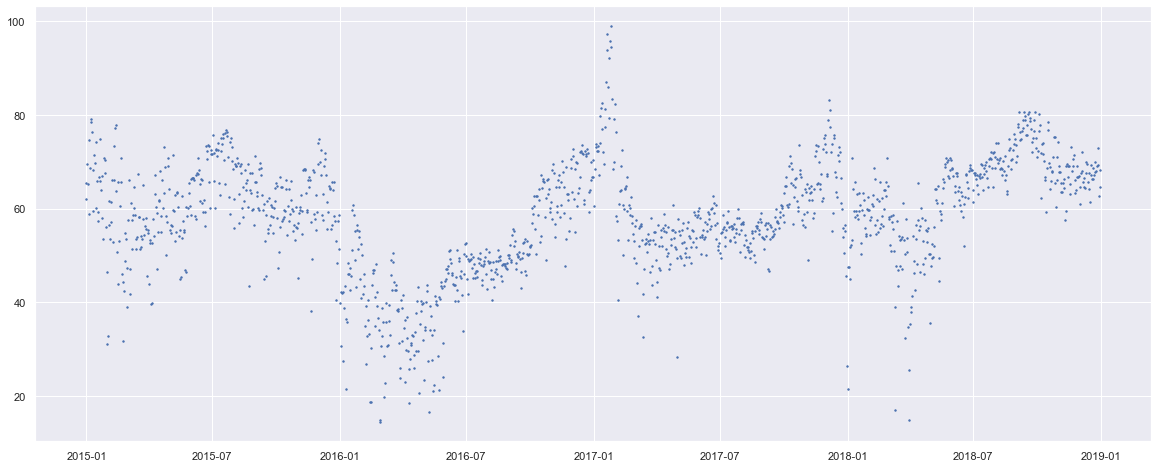

In [27]:
plt.figure(figsize=(20,8))
plt.scatter(price_actual_means_daily.index, price_actual_means_daily, s = 2)
plt.show()

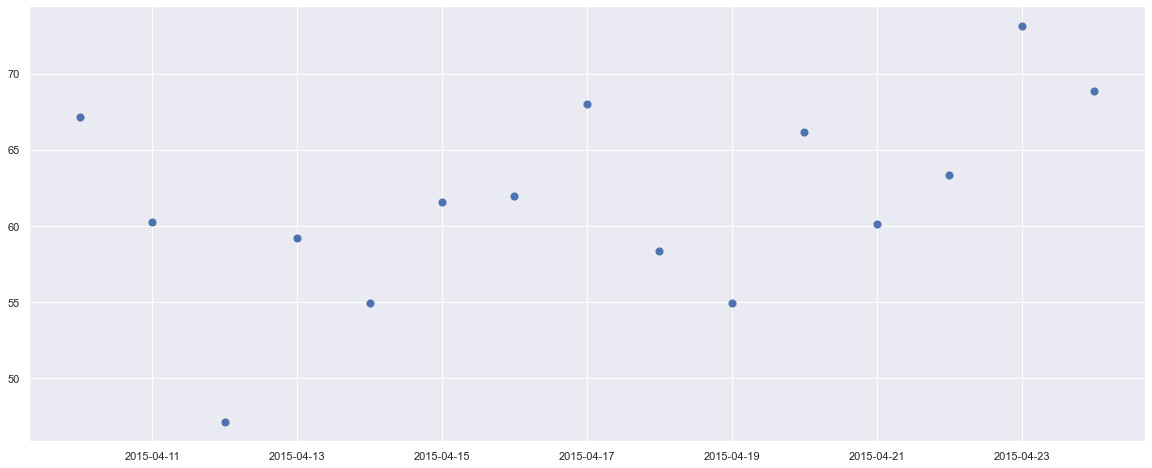

In [28]:
plt.figure(figsize=(20,8))
plt.scatter(price_actual_means_daily.index[100:115], price_actual_means_daily[100:115], s = 50)
plt.show()

In [29]:
df_data = df_data.drop("date", axis = 1)

In [30]:
print(df_data.columns.tolist()), df_data.shape

['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind onshore', 'total load actual', 'price actual', 'temp_Barcelona', 'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona', 'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona', 'rain_1h_Barcelona', 'snow_3h_Barcelona', 'clouds_all_Barcelona', 'weather_main_clear_Barcelona', 'weather_main_clouds_Barcelona', 'weather_main_drizzle_Barcelona', 'weather_main_dust_Barcelona', 'weather_main_fog_Barcelona', 'weather_main_haze_Barcelona', 'weather_main_mist_Barcelona', 'weather_main_rain_Barcelona', 'weather_main_smoke_Barcelona', 'weather_main_snow_Barcelona', 'weather_main_squ

(None, (35064, 126))

## Price - Decomposition and stationarity tests

In [ ]:
"""
Компоненти на времеви редове

Полезна абстракция за избор на методи за прогнозиране е разбиването на времеви редове на систематични и несистематични 
компоненти.

- Систематичен : Компоненти на времевата поредица, които имат последователност или повтаряемост и могат да бъдат описани и моделирани.
- Несистематични : Компоненти на времевия ред, които не могат да бъдат директно моделирани.

Смята се, че даден времеви ред се състои от три систематични компонента, включително ниво, тенденция, 
сезонност и един несистематичен компонент, наречен шум.

Тези компоненти се определят, както следва:

    Ниво : Средната стойност в серията.
    Тенденция : Нарастващата или намаляваща стойност в серията.
    Сезонност : Повтарящият се краткосрочен цикъл в серията.
    Шум : Случайната вариация в серията

Декомпозицията представлява разлагане на времевите редове. И има основно два типа модели:
y(t) = Level + Trend + Seasonality + Noise --- Адитивен модел 
y(t) = Level * Trend * Seasonality * Noise --- Мултипликативен модел 

Библиотеката statsmodels предоставя имплементация на наивния или класически метод на 
декомпозиция във функция, наречена seasonal_decompose() .

http://mitko.villaverde-bansko.com/Statistika/glava-7-2.html
"""

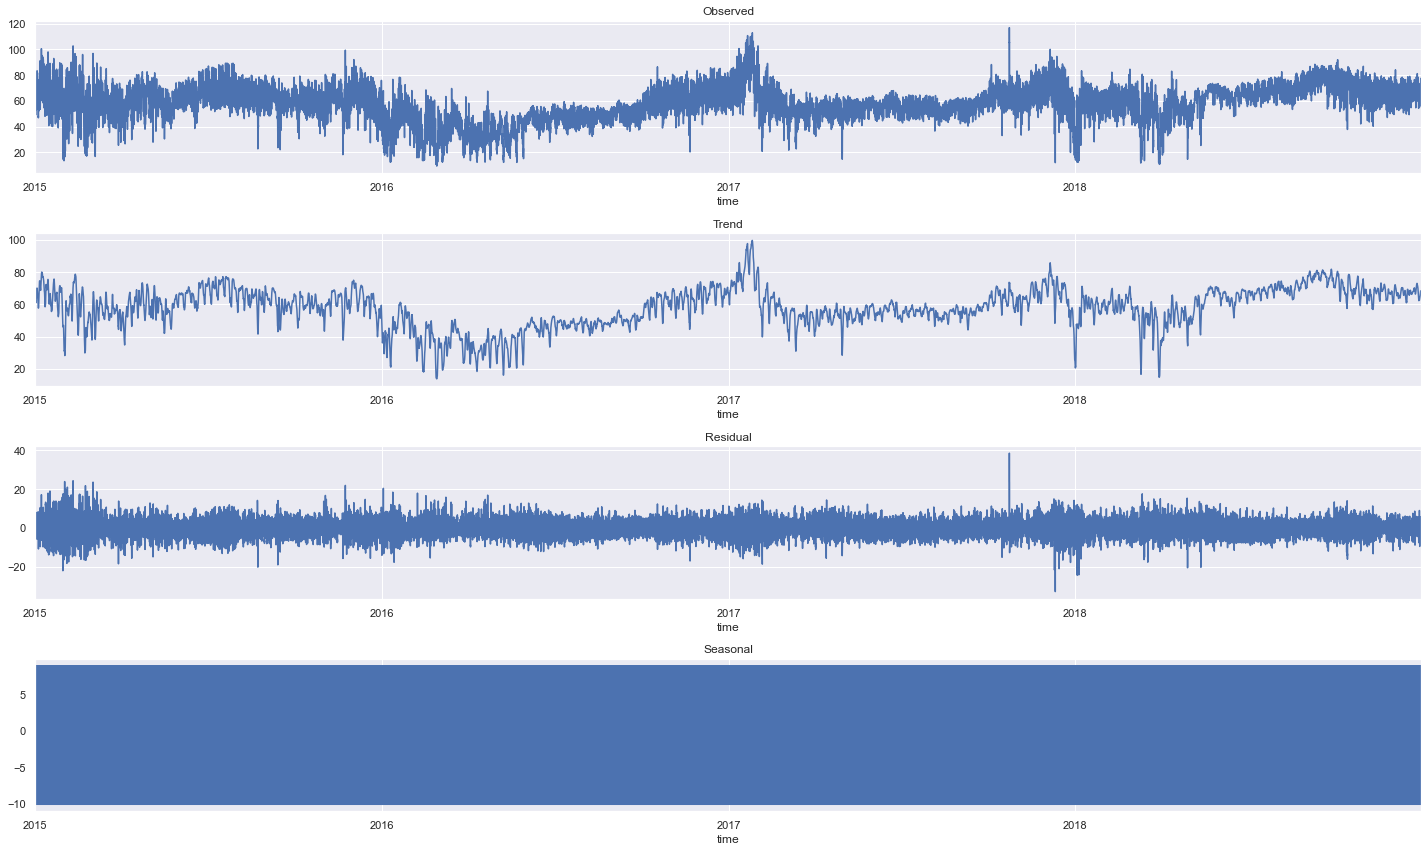

In [60]:
# Decompose the electricity price time series
# Линеен тренд, Ползваме Адитивен модел

res = sm.tsa.seasonal_decompose(df_data['price actual'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

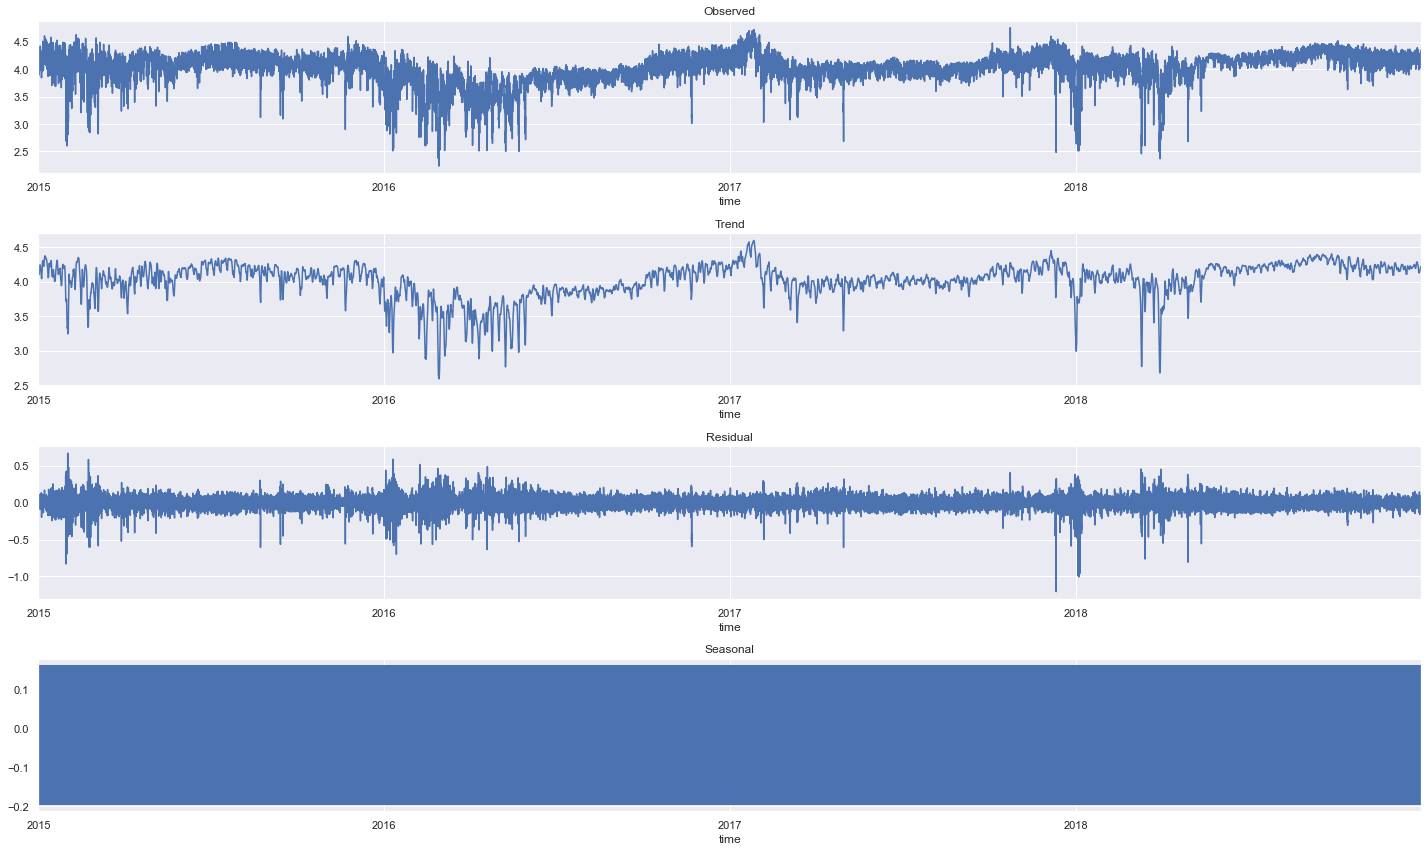

In [61]:
# Decompose the log electricity price time-series
# Логаритмичен тренд

res = sm.tsa.seasonal_decompose(np.log(df_data['price actual']), model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

In [63]:
"""
The Augmented Dickey-Fuller (ADF) test

Разширеният тест на Дики-Фулър (ADF), вид тест за единичен корен, определя доколко времевата серия е дефинирана от 
тенденция. Хипотезите му са следните:
- Нулева хипотеза H0 : Има единичен корен във времевата поредица, 
    т.е. поредицата е автокорелирана с (r=1), зависима от времето структура и следователно не е стационарна.
- Алтернативна хипотеза H1 : Времевият ред няма единичен корен и е или стационарен, 
    или може да бъде направен стационарен с помощта на диференциране.

*** Един динамичен ред се нарича стационаренако неговото средно, дисперсия и автокорелационна функция не се изменят във времето.
Наличието или отсъствието на стационарностсе вижда от линейната диаграма на данните.    
"""

In [66]:
y = df_data['price actual']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

# Статистиката на ADF (-9,147) е по-малка от критичната стойност при 1% (-3,431) и по този начин,
# можем да кажем, че отхвърляме нулевата хипотеза H0 с ниво на значимост 1%.
# Т.е. реда е или стационарен или може да бъде направен стационарен.

ADF Statistic: -9.147016
p-value: 0.000000
#Lags used: 50
Critical Value (1%): -3.430537
Critical Value (5%): -2.861623
Critical Value (10%): -2.566814


In [64]:
# The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, follows the opposite logic from Augmented Dickey-Fuller test and checks for stationarity. Its hypotheses are the following:

#     Null Hypothesis H0
# : The time series is level, i.e. it is stationary around a constant.

# Alternate Hypothesis H1
# : There is a unit root in the time series and thus it not stationary.

# Тестът, предложен от KPSS разменя нулевата и алтернативната хипотеза и изследва динамичния ред
# за стационарност при нулевата хипотеза.

In [65]:
kpss_test = kpss(y, regression='c', nlags="legacy")
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))
    
"""
KPSS статистиката (7,957) е по-висока от критичната стойност при 1% (0,739) и по този начин, можем да кажем, 
че не можем да отхвърлим нулевата хипотеза H0 с ниво на значимост 1%. Следователно времевият ред е стационарен или 
стационарен около константа.
И двата теста заключиха, че времевият ред на цената на електроенергията е стационарен.

"""

KPSS Statistic: 7.957007
p-value: 0.010000
#Lags used: 52
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\statsmodels\tsa\stattools.py:2011: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


# Price - Autocorrelation, partial autocorrelation and cross-correlation

C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


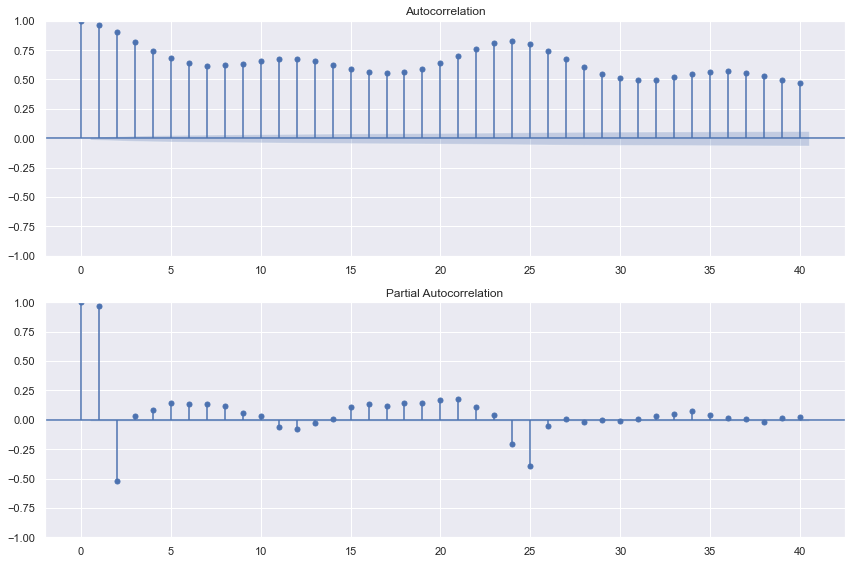

In [44]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8))
plot_acf(df_data['price actual'], lags=40, ax=ax1)
plot_pacf(df_data['price actual'], lags=40, ax=ax2)
plt.tight_layout()
plt.show()



In [ ]:
"""
Графиката на частичната автокорелация на времевия ред на цените на електроенергията показва, 
че пряката връзка между наблюдение в даден час (t) е най-силна с наблюденията в t-1, t-2, t-24 и t-25 времеви стъпки 
и намалява след това. 

Независимо от това, определено би било по-полезно, ако изберем да използваме само конкретни минали стойности 
(наблюдения при определени времеви интервали) на дадена характеристика, въз основа на кръстосаната корелация между 
цената на електроенергията и всяка една от характеристиките в набора от данни . 
Например по-долу можем да видим кръстосаната корелация между цената на електроенергията и общия товар. 
Виждаме, че има много забавяния във времето с корелация, която е близка до нула и може да бъде пропусната.
"""

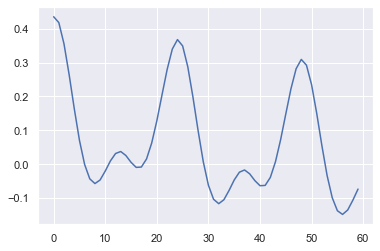

In [48]:
figsize=(12, 8)
cross_corr = ccf(df_data['total load actual'], df_data['price actual'])
plt.plot(cross_corr[0:60])
plt.show()

In [49]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_data.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Barcelona                             0.246969
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133141
weather_main_clear_Bilbao                      0.106470
temp_min_Barcelona                             0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0.096279
temp_Valencia                                  0

In [59]:
columns = pd.DataFrame(correlations['price actual'].sort_values(ascending=False))
names = columns.loc[pd.isnull(columns['price actual'])].index.to_list()

In [67]:
# df_data = df_data.drop(names, axis=1) по добре да ги видя с PCA - няма да се махат на този етап
names

['snow_3h_Barcelona',
 'weather_main_haze_Barcelona',
 'weather_main_smoke_Barcelona',
 'weather_main_squall_Barcelona',
 'weather_main_dust_Bilbao',
 'weather_main_smoke_Bilbao',
 'weather_main_squall_Bilbao',
 'weather_main_dust_Madrid',
 'weather_main_smoke_Madrid',
 'weather_main_squall_Madrid',
 'snow_3h_Seville',
 'weather_main_snow_Seville',
 'weather_main_dust_Valencia',
 'weather_main_snow_Valencia',
 'weather_main_squall_Valencia']

## Electricity Load Analysis

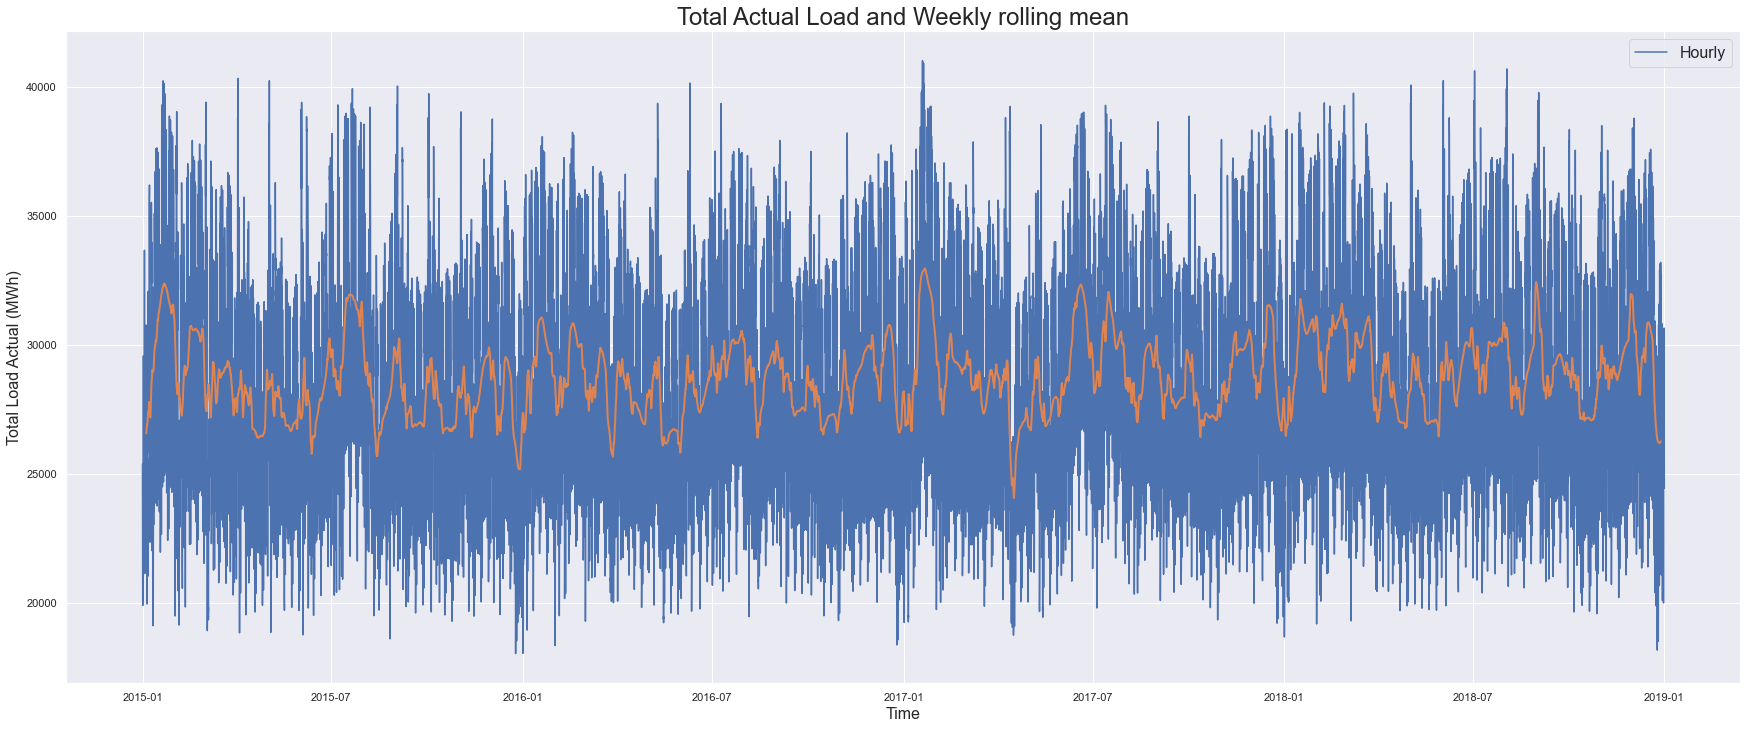

In [69]:
# Plot the hourly actual electricity load, along with the weekly rolling mean
rolling = df_data['total load actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_data, 'total load actual', label='Hourly', ylabel='Total Load Actual (MWh)',
                 title='Total Actual Load and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')

plt.show()

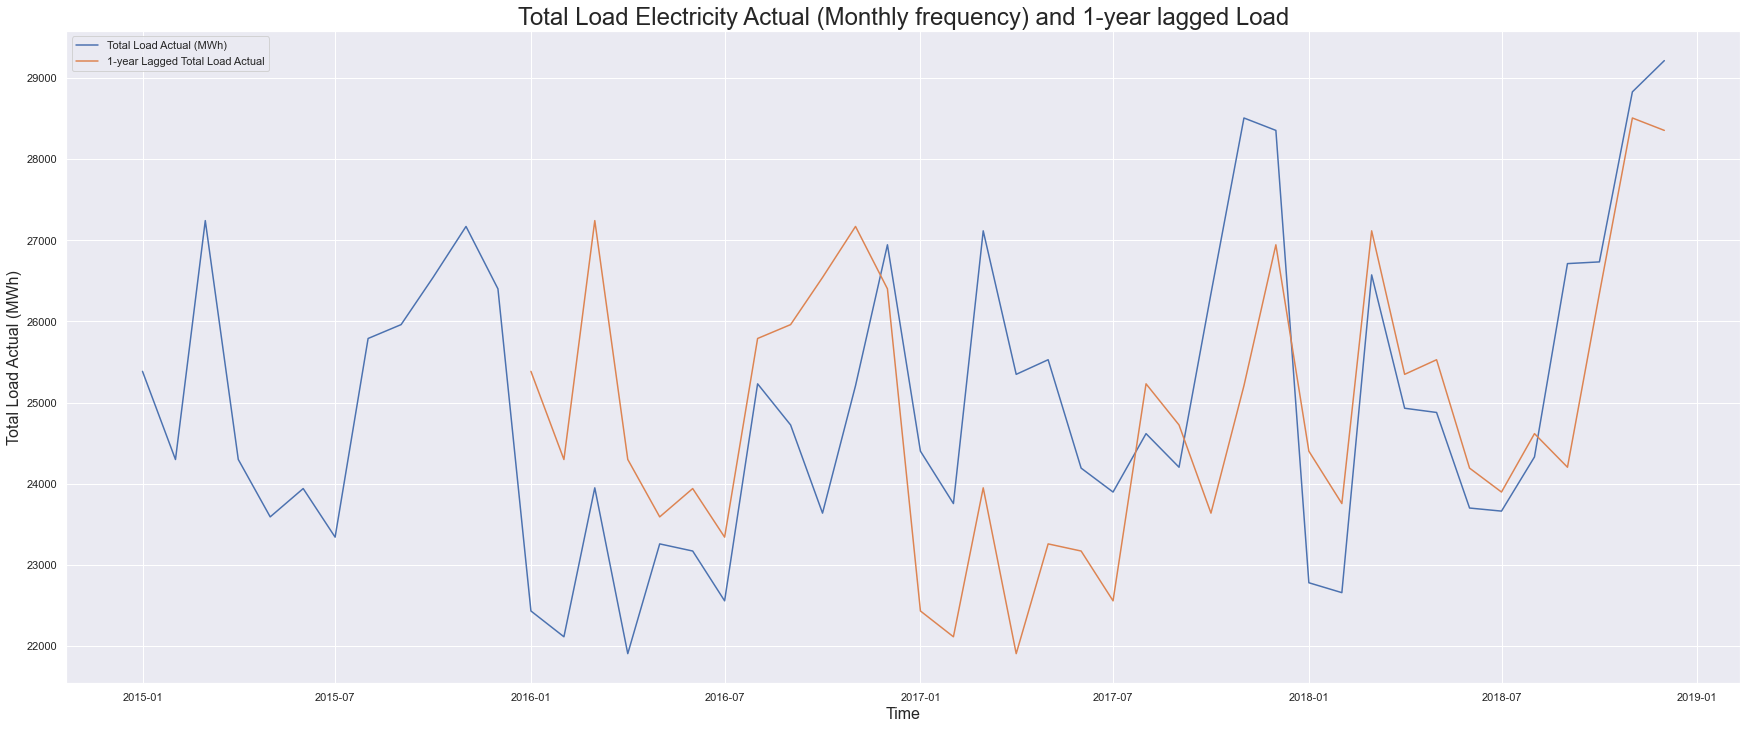

In [70]:
# Plot the hourly actual electricity load (monthly frequence) along with its 1-year lagged series
monthly_price = df_data['total load actual'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Total Load Actual (MWh)',
                 title='Total Load Electricity Actual (Monthly frequency) and 1-year lagged Load')
shifted = df_data['total load actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Total Load Actual (MWh)', '1-year Lagged Total Load Actual'])
plt.show()

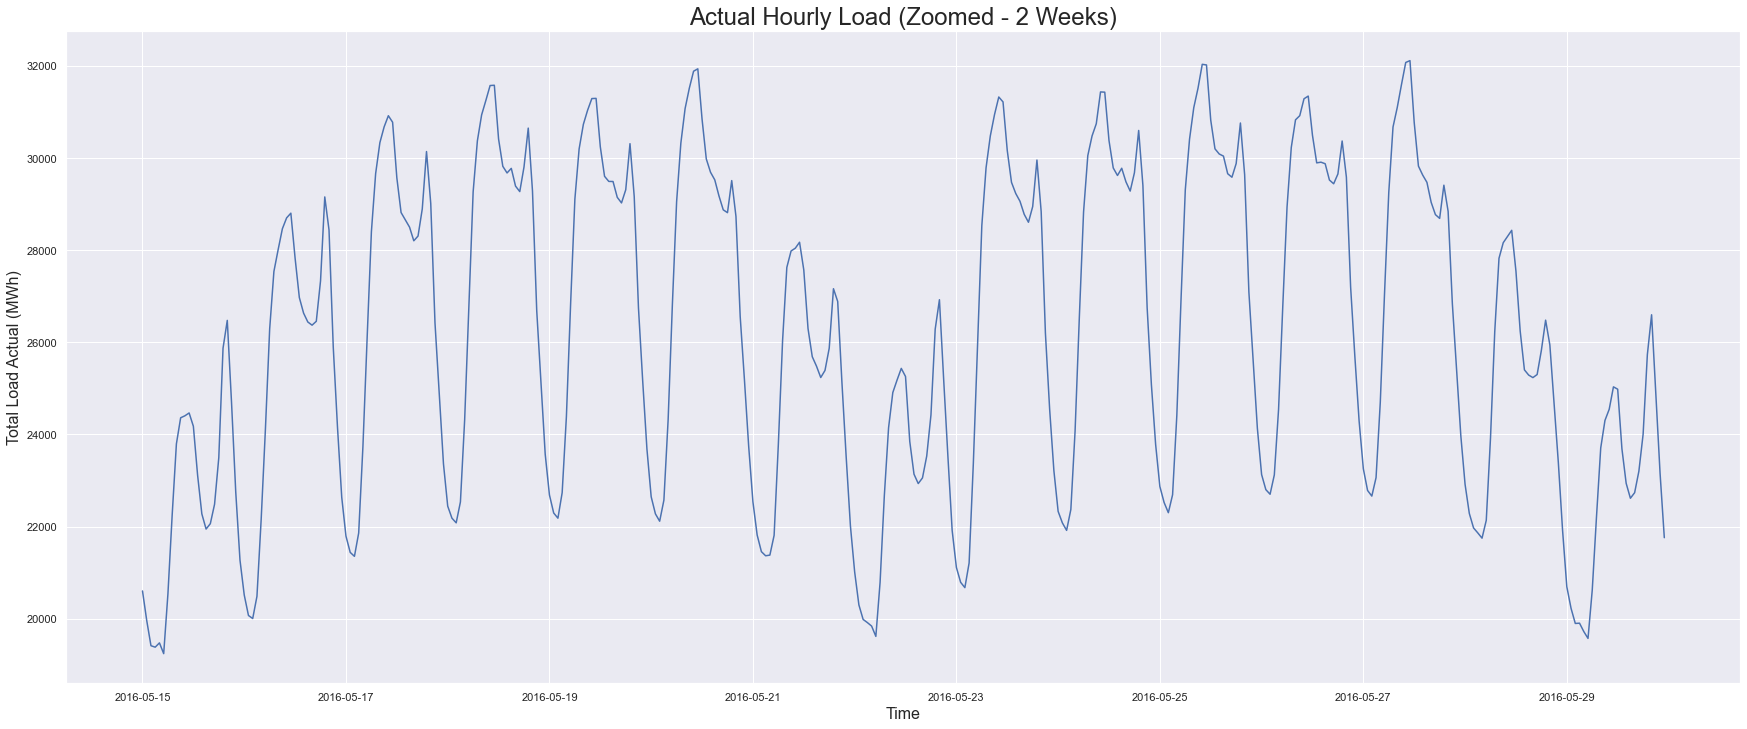

In [71]:
# Plot the actual electricity load at a daily/weekly scale
ax = plot_series(df_data, 'total load actual', ylabel='Total Load Actual (MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Load (Zoomed - 2 Weeks)')
plt.show()

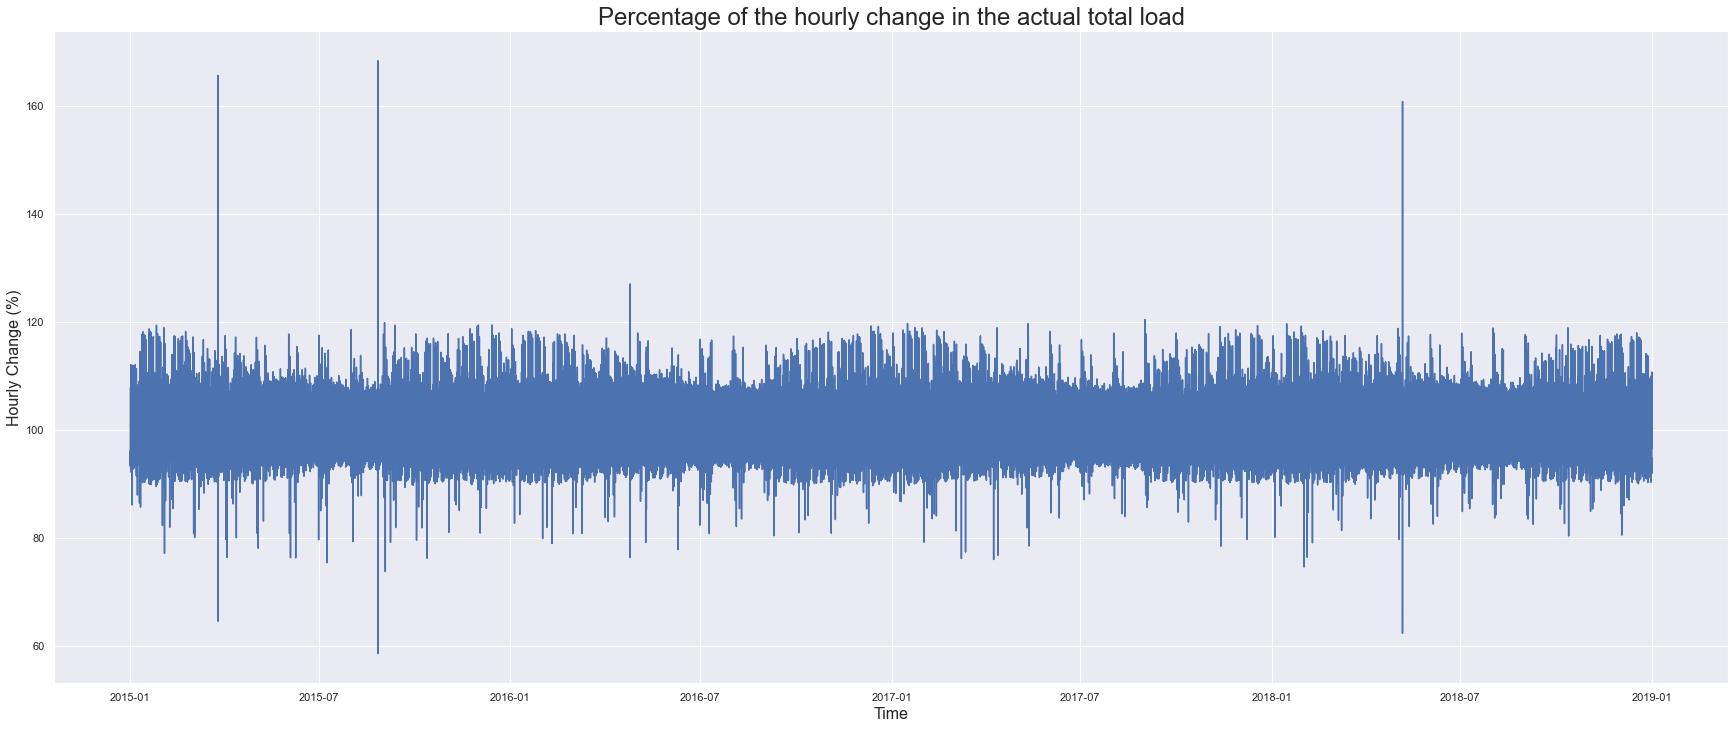

In [72]:
# Plot the percentage of the hourly change in the actual total load

change = df_data['total load actual'].div(df_data['total load actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change in the actual total load')
plt.show()

In [81]:
change[change>140].to_list()
# change[change. > 200]

[165.56225845979827, 168.3122045552213, 160.73933079543175]

In [83]:
change[change<65].to_list()

[64.53948168876992, 58.535358299531495, 62.294058911632554]

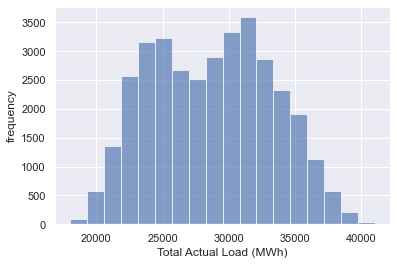

In [84]:
ax = df_data['total load actual'].plot.hist(bins=18, alpha=0.65)
plt.xlabel('Total Actual Load (MWh)')
plt.ylabel('frequency')
plt.show()
# bimodal distribution

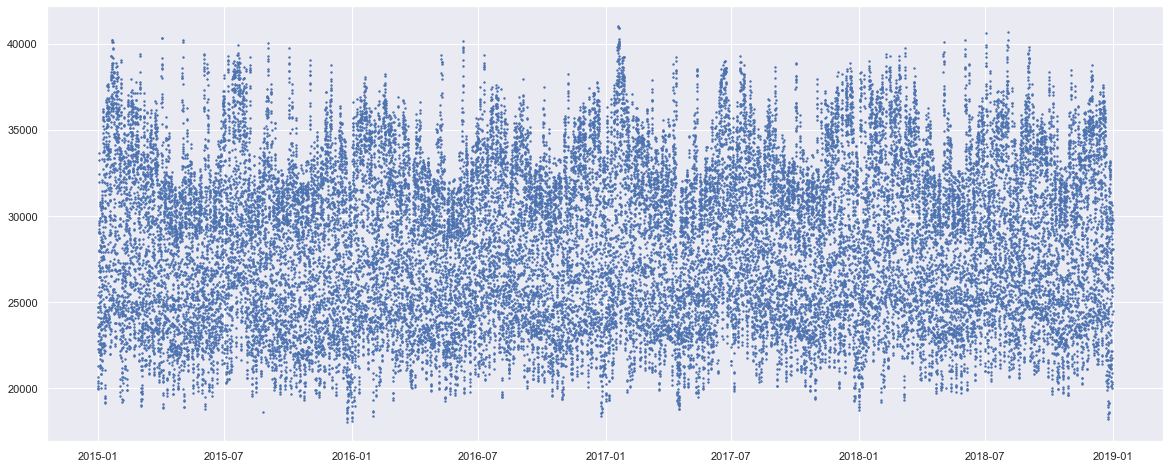

In [33]:
plt.figure(figsize=(20,8))
plt.scatter(df_data.index, df_data['total load actual'], s = 2)
plt.show()

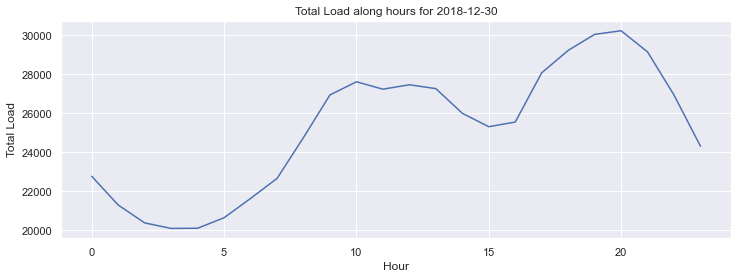

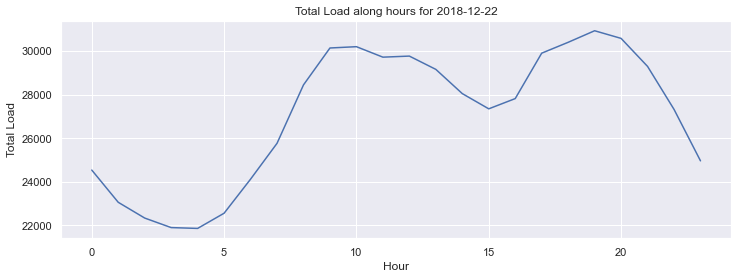

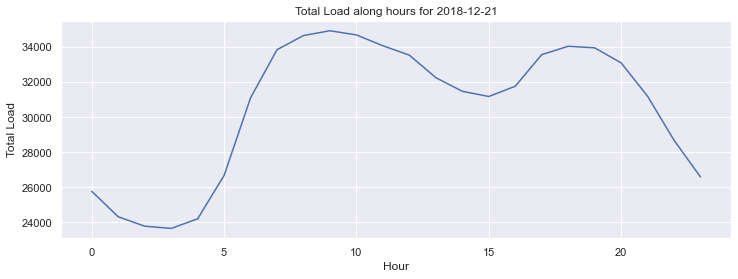

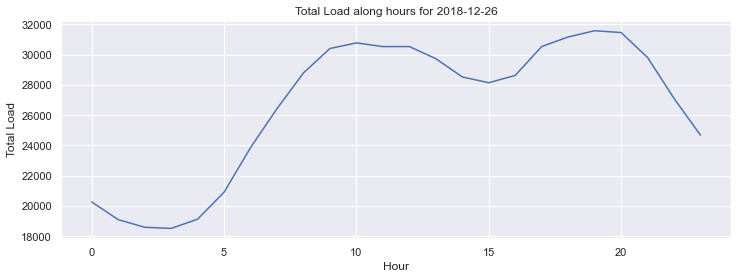

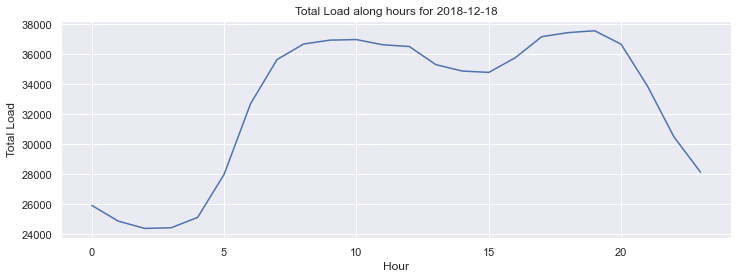

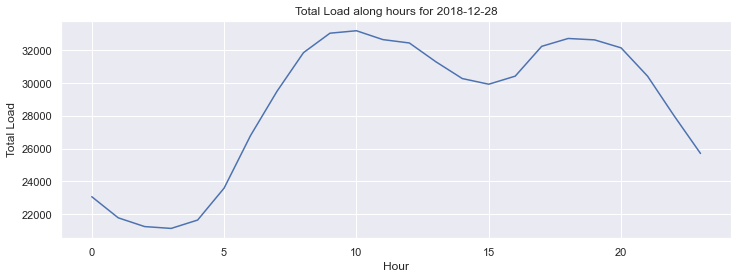

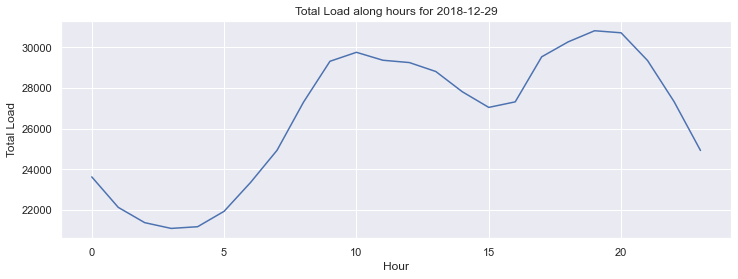

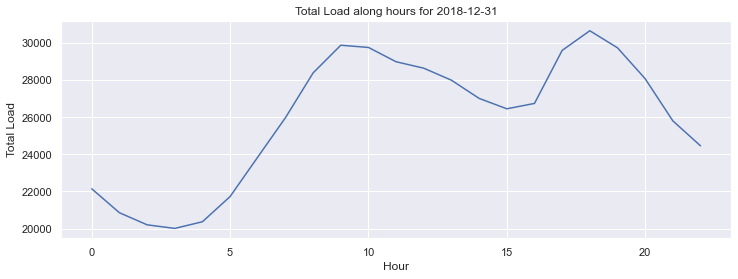

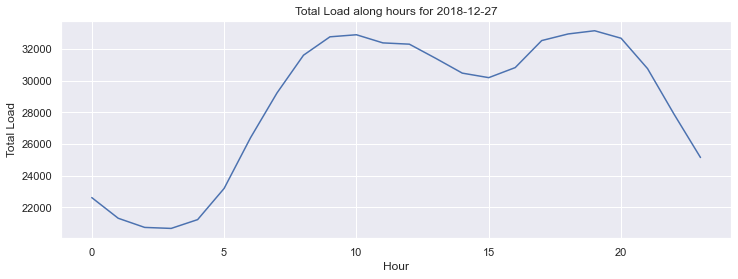

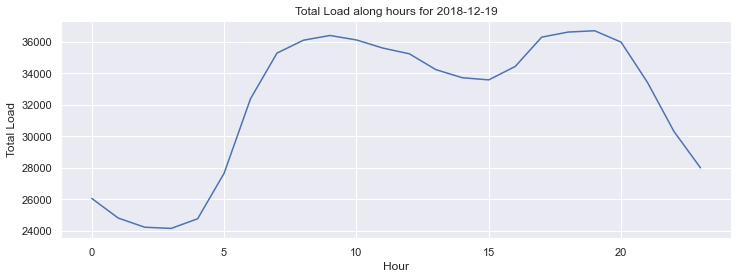

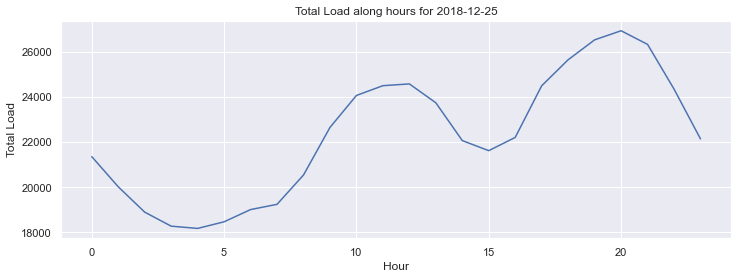

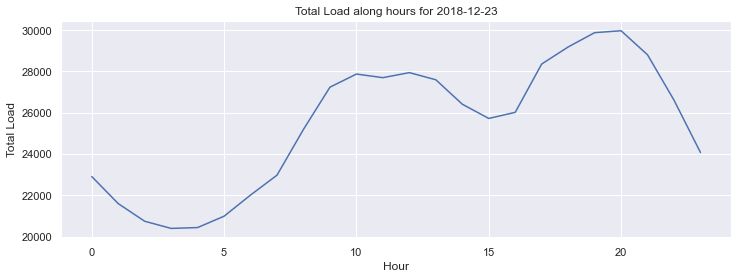

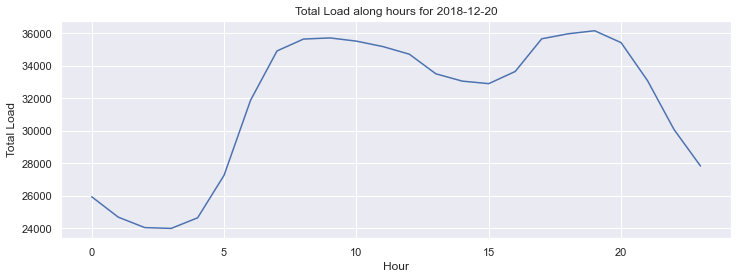

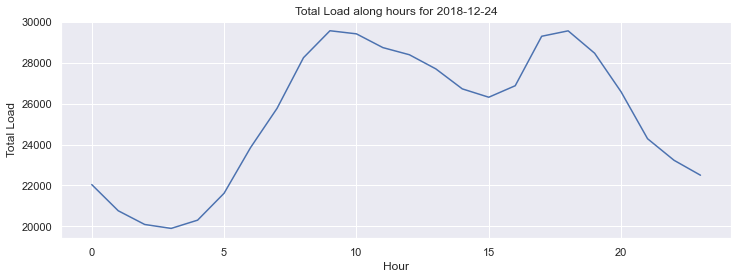

In [34]:
for date in df_last:
    plt.figure(figsize=(12,4))
    day_meas =  df_data[df_data.index.date == date]
    plt.plot(day_meas.index.hour, day_meas['total load actual'])
    plt.title(f"Total Load along hours for {date}" )
    plt.xlabel("Hour")
    plt.ylabel("Total Load")
    plt.show()

In [85]:
df_data["date"] = df_data.index.date

In [87]:
total_load_actual_means_daily = df_data.groupby("date")["total load actual"].mean()
total_load_actual_means_daily

date
2014-12-31    25385.000000
2015-01-01    23966.958333
2015-01-02    27188.541667
2015-01-03    25097.750000
2015-01-04    27104.916667
                  ...     
2018-12-27    28551.708333
2018-12-28    28661.166667
2018-12-29    26603.958333
2018-12-30    25238.500000
2018-12-31    25966.173913
Name: total load actual, Length: 1462, dtype: float64

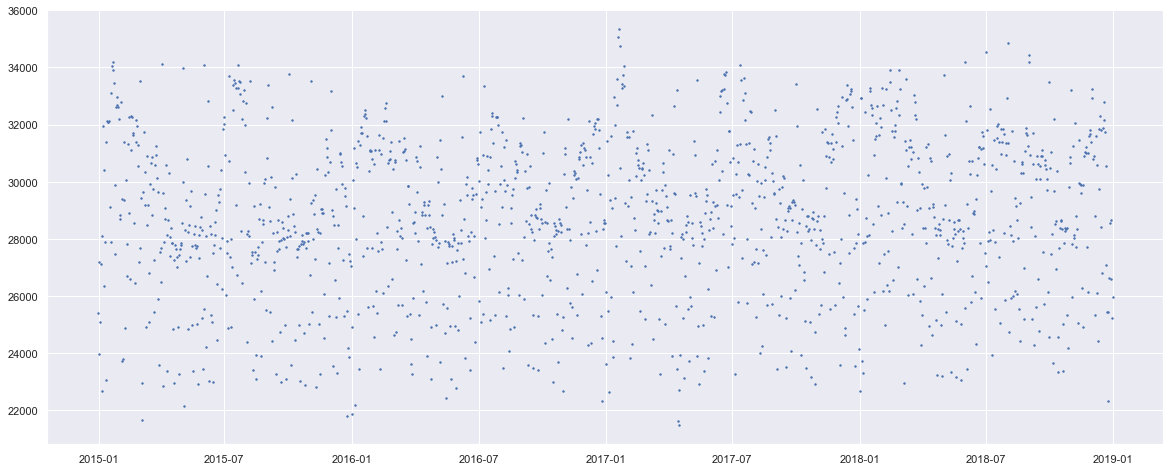

In [88]:
plt.figure(figsize=(20,8))
plt.scatter(total_load_actual_means_daily.index, total_load_actual_means_daily, s = 2)
plt.show()

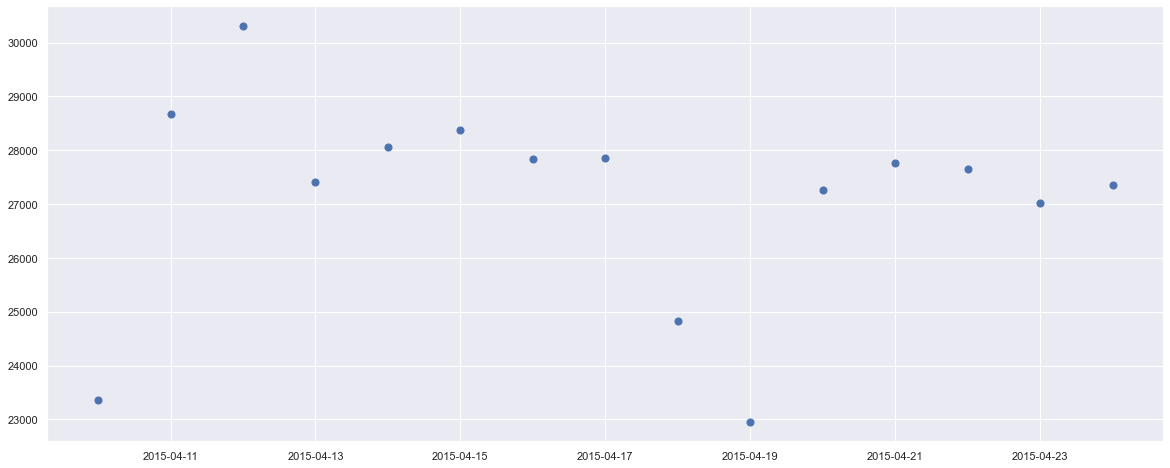

In [89]:
plt.figure(figsize=(20,8))
plt.scatter(total_load_actual_means_daily.index[100:115], total_load_actual_means_daily[100:115], s = 50)
plt.show()

In [90]:
df_data = df_data.drop("date", axis = 1)

## Load - Decomposition and stationarity tests

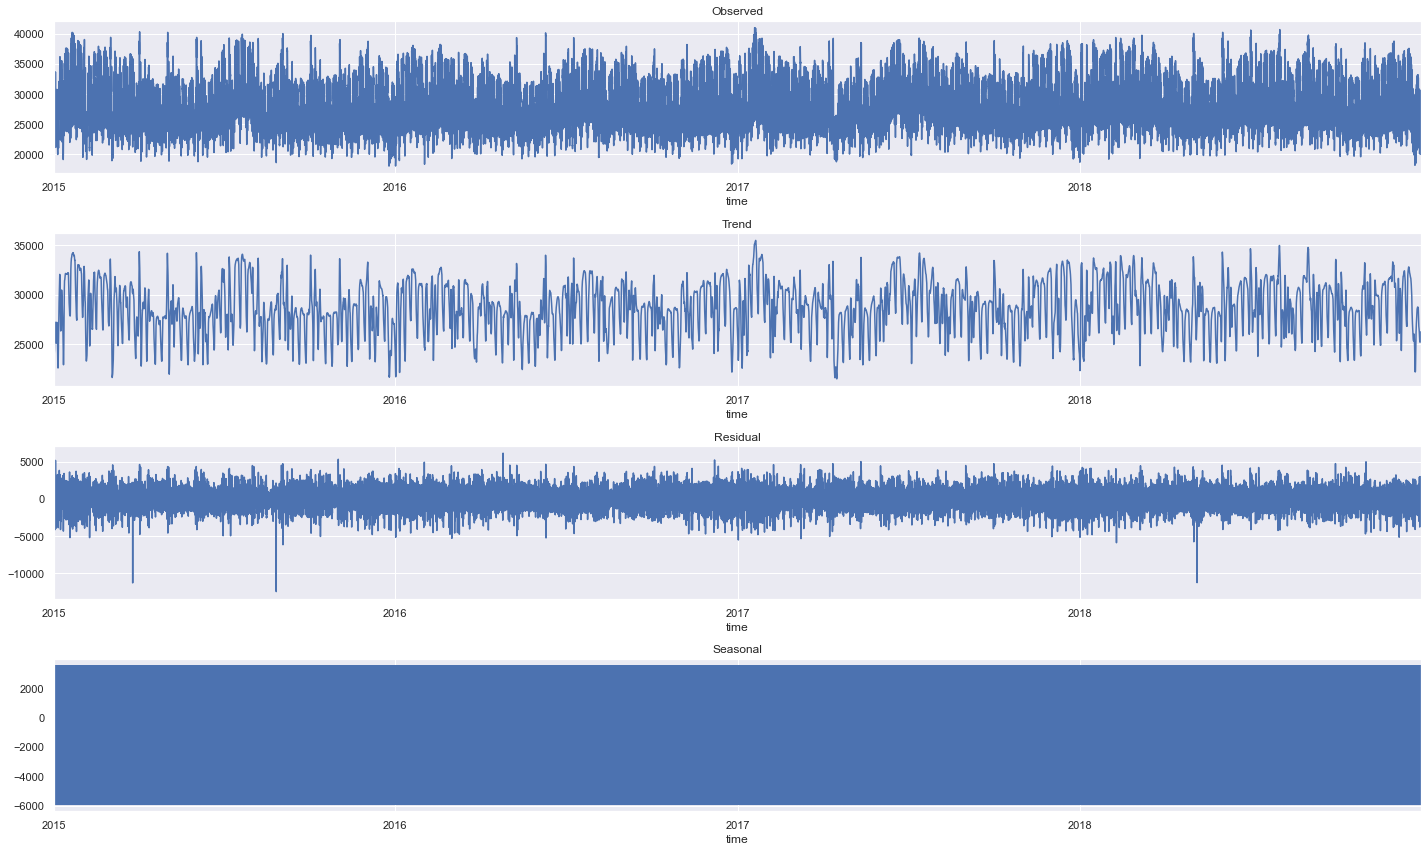

In [91]:
# Decompose the electricity load time series
# Линеен тренд

res = sm.tsa.seasonal_decompose(df_data['total load actual'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

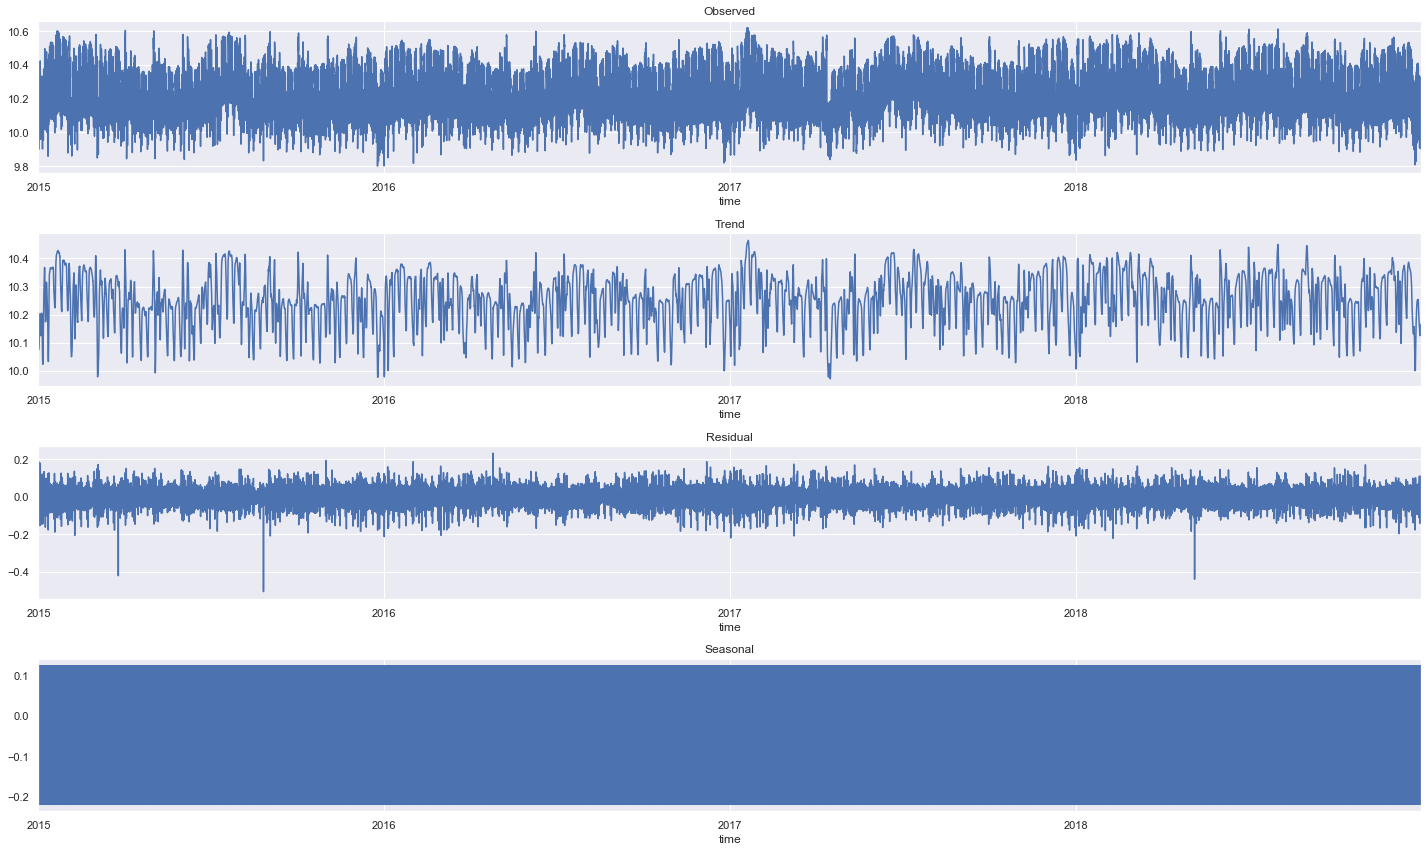

In [92]:
# Decompose the log electricity load time-series
# Логаритмичен тренд

res = sm.tsa.seasonal_decompose(np.log(df_data['total load actual']), model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

In [93]:
y = df_data['total load actual']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -21.420316
p-value: 0.000000
#Lags used: 52
Critical Value (1%): -3.430537
Critical Value (5%): -2.861623
Critical Value (10%): -2.566814


In [64]:
# Статистиката на ADF ( -21.420316) е по-малка от критичната стойност при 1% (-3,431) и по този начин,
# можем да кажем, че отхвърляме нулевата хипотеза H0 с ниво на значимост 1%.
# Т.е. реда е или стационарен или може да бъде направен стационарен.

In [94]:
kpss_test = kpss(y, regression='c', nlags="legacy")
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 0.936473
p-value: 0.010000
#Lags used: 52
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\statsmodels\tsa\stattools.py:2011: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [ ]:
# KPSS статистиката (0.936473) е по-висока от критичната стойност при 1% (0.739000) и по този начин, можем да кажем, 
# че не можем да отхвърлим нулевата хипотеза H0 с ниво на значимост 1%. Следователно времевият ред е стационарен или 
# стационарен около константа.
# И двата теста заключиха, че времевият ред на цената на електроенергията е стационарен.

# Load - Autocorrelation, partial autocorrelation and cross-correlation

C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


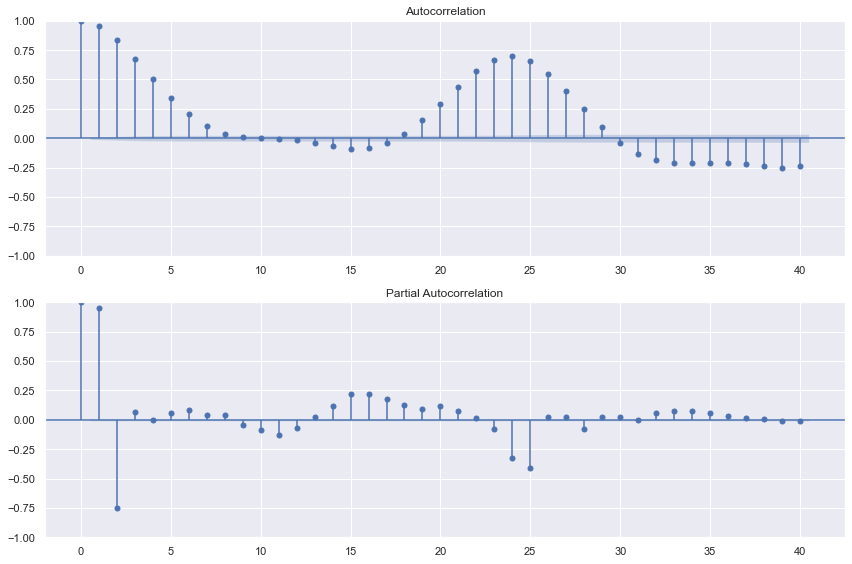

In [95]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8))
plot_acf(df_data['total load actual'], lags=40, ax=ax1)
plot_pacf(df_data['total load actual'], lags=40, ax=ax2)
plt.tight_layout()
plt.show()



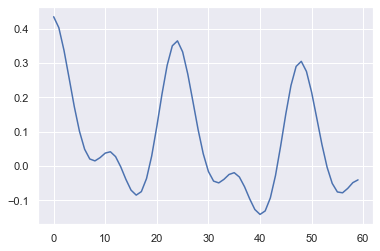

In [97]:
figsize=(12, 8)
cross_corr = ccf(df_data['price actual'], df_data['total load actual'])
plt.plot(cross_corr[0:60])
plt.show()

In [98]:
# Find the correlations between the total load actual and the rest of the features

correlations = df_data.corr(method='pearson')
print(correlations['total load actual'].sort_values(ascending=False).to_string())

total load actual                              1.000000
generation fossil gas                          0.548986
generation fossil oil                          0.496139
generation hydro water reservoir               0.479491
price actual                                   0.435253
generation fossil hard coal                    0.397079
generation solar                               0.395511
generation fossil brown coal/lignite           0.280735
temp_min_Valencia                              0.235297
temp_Valencia                                  0.220790
temp_min_Seville                               0.206488
temp_max_Madrid                                0.204718
temp_Seville                                   0.204571
temp_max_Valencia                              0.199833
temp_Bilbao                                    0.196535
temp_max_Bilbao                                0.194181
temp_min_Bilbao                                0.193706
temp_min_Barcelona                             0

In [100]:
columns_l = pd.DataFrame(correlations['total load actual'].sort_values(ascending=False))
names_l = columns_l.loc[pd.isnull(columns_l['total load actual'])].index.to_list()

In [101]:
# df_data = df_data.drop(names_l, axis=1) по добре да ги видя с PCA - няма да се махат на този етап
names_l

['snow_3h_Barcelona',
 'weather_main_haze_Barcelona',
 'weather_main_smoke_Barcelona',
 'weather_main_squall_Barcelona',
 'weather_main_dust_Bilbao',
 'weather_main_smoke_Bilbao',
 'weather_main_squall_Bilbao',
 'weather_main_dust_Madrid',
 'weather_main_smoke_Madrid',
 'weather_main_squall_Madrid',
 'snow_3h_Seville',
 'weather_main_snow_Seville',
 'weather_main_dust_Valencia',
 'weather_main_snow_Valencia',
 'weather_main_squall_Valencia']

## Prepare DataSets for Time Series  

In [104]:
df_data

generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   
...                                       ...   
2018-12-31 18:00:00+00:00               297.0   
2018-12-31 19:00:00+00:00               296.0   
2018-12-31 20:00:00+00:00               292.0   
2018-12-31 21:00:00+00:00               293.0   
2018-12-31 22:00:00+00:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   
...                                                         ...   
2018-12-31 18:00:00+00:00                                   0.0   
2018-12-31 19:00:00+00:00                                   0.0   
2018-12-31 20:00:00+00:00                                   0.0   
2018-12-31 21:00:00+00:00                                   0.0   
2018-12-31 22:00:00+00:00                                   0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   
...                                          ...                          ...   
2018-12-31 18:00:00+00:00                 7634.0                       2628.0   
2018-12-31 19:00:00+00:00                 7241.0                       2566.0   
2018-12-31 20:00:00+00:00                 7025.0                       2422.0   
2018-12-31 21:00:00+00:00                 6562.0                       2293.0   
2018-12-31 22:00:00+00:00                 6926.0                       2166.0   

                           generation fossil oil  \
time                                               
2014-12-31 23:00:00+00:00                  162.0   
2015-01-01 00:00:00+00:00                  158.0   
2015-01-01 01:00:00+00:00                  157.0   
2015-01-01 02:00:00+00:00                  160.0   
2015-01-01 03:00:00+00:00                  156.0   
...                                          ...   
2018-12-31 18:00:00+00:00                  178.0   
2018-12-31 19:00:00+00:00                  174.0   
2018-12-31 20:00:00+00:00                  168.0   
2018-12-31 21:00:00+00:00                  163.0   
2018-12-31 22:00:00+00:00                  163.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2014-12-31 23:00:00+00:00                                        863.0   
2015-01-01 00:00:00+00:00                                        920.0   
2015-01-01 01:00:00+00:00                                       1164.0   
2015-01-01 02:00:00+00:00                                       1503.0   
2015-01-01 03:00:00+00:00                                       1826.0   
...                                                                ...   
2018-12-31 18:00:00+00:00                                          1.0   
2018-12-31 19:00:00+00:00                                          1.0   
2018-12-31 20:00:00+00:00                     

In [5]:
df_data.to_csv('output_data_sets/df_data_before_tsa.csv', index=True)

In [1]:
# df_data_final = pd.read_csv(r"output_data_sets/df_data_before_tsa.csv", sep=',')
# df_data_final

### Load DataSet

In [2]:
# df_data_final = pd.read_csv(r"output_data_sets/df_data_before_tsa.csv", sep=',')
# df_data_final

#   <span style="color:red">   *** Тази част е отделена в нов файл<span>

### Price DataSet   <span style="color:red">   *** Тази част е отделена в нов файл<span>

In [13]:
tsa_price = prepare_windows(df_data_final[['time', 'price actual']], 720,'price actual')
tsa_price

<ipython-input-3-202f4afc4273>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ts_dataset[f"Lag_{i}"] = df[col_name].shift(i)


time  price actual  Lag_1  Lag_2  Lag_3  Lag_4  \
720    2015-01-30 23:00:00+00:00         30.14  45.04  54.74  60.29  65.98   
721    2015-01-31 00:00:00+00:00         24.91  30.14  45.04  54.74  60.29   
722    2015-01-31 01:00:00+00:00         17.23  24.91  30.14  45.04  54.74   
723    2015-01-31 02:00:00+00:00         16.10  17.23  24.91  30.14  45.04   
724    2015-01-31 03:00:00+00:00         14.27  16.10  17.23  24.91  30.14   
...                          ...           ...    ...    ...    ...    ...   
35059  2018-12-31 18:00:00+00:00         77.02  77.61  75.13  71.36  70.85   
35060  2018-12-31 19:00:00+00:00         76.16  77.02  77.61  75.13  71.36   
35061  2018-12-31 20:00:00+00:00         74.30  76.16  77.02  77.61  75.13   
35062  2018-12-31 21:00:00+00:00         69.89  74.30  76.16  77.02  77.61   
35063  2018-12-31 22:00:00+00:00         69.88  69.89  74.30  76.16  77.02   

       Lag_5  Lag_6  Lag_7  Lag_8  ...  Lag_711  Lag_712  Lag_713  Lag_714  \
720    69.55  67.39  55.14  48.77  ...    54.20    48.98    51.43    51.73   
721    65.98  69.55  67.39  55.14  ...    58.94    54.20    48.98    51.43   
722    60.29  65.98  69.55  67.39  ...    59.86    58.94    54.20    48.98   
723    54.74  60.29  65.98  69.55  ...    60.12    59.86    58.94    54.20   
724    45.04  54.74  60.29  65.98  ...    62.05    60.12    59.86    58.94   
...      ...    ...    ...    ...  ...      ...      ...      ...      ...   
35059  71.95  71.80  72.42  71.81  ...    50.25    50.03    51.32    53.37   
35060  70.85  71.95  71.80  72.42  ...    50.98    50.25    50.03    51.32   
35061  71.36  70.85  71.95  71.80  ...    51.73    50.98    50.25    50.03   
35062  75.13  71.36  70.85  71.95  ...    51.42    51.73    50.98    50.25   
35063  77.61  75.13  71.36  70.85  ...    52.01    51.42    51.73    50.98   

       Lag_715  Lag_716  Lag_717  Lag_718  Lag_719  Lag_720  
720      53.63    56.04    59.32    64.48    64.92    65.41  
721      51.73    53.63    56.04    59.32    64.48    64.92  
722      51.43    51.73    53.63    56.04    59.32    64.48  
723      48.98    51.43    51.73    53.63    56.04    59.32  
724      54.20    48.98    51.43    51.73    53.63    56.04  
...        ...      ...      ...      ...      ...      ...  
35059    60.27    64.50    67.69    69.72    70.48    72.72  
35060    53.37    60.27    64.50    67.69    69.72    70.48  
35061    51.32    53.37    60.27    64.50    67.69    69.72  
35062    50.03    51.32    53.37    60.27    64.50    67.69  
35063    50.25    50.03    51.32    53.37    60.27    64.50  

[34344 rows x 722 columns]

In [14]:
df_data_final.shape, tsa_price.shape

((35064, 127), (34344, 722))

In [16]:
df_data_final = df_data_final.drop(['price actual'], axis = 1)
tsa_price_exog = pd.merge(tsa_price, df_data_final, left_on = 'time', right_on='time')
tsa_price_exog

time  price actual  Lag_1  Lag_2  Lag_3  Lag_4  \
0      2015-01-30 23:00:00+00:00         30.14  45.04  54.74  60.29  65.98   
1      2015-01-31 00:00:00+00:00         24.91  30.14  45.04  54.74  60.29   
2      2015-01-31 01:00:00+00:00         17.23  24.91  30.14  45.04  54.74   
3      2015-01-31 02:00:00+00:00         16.10  17.23  24.91  30.14  45.04   
4      2015-01-31 03:00:00+00:00         14.27  16.10  17.23  24.91  30.14   
...                          ...           ...    ...    ...    ...    ...   
34339  2018-12-31 18:00:00+00:00         77.02  77.61  75.13  71.36  70.85   
34340  2018-12-31 19:00:00+00:00         76.16  77.02  77.61  75.13  71.36   
34341  2018-12-31 20:00:00+00:00         74.30  76.16  77.02  77.61  75.13   
34342  2018-12-31 21:00:00+00:00         69.89  74.30  76.16  77.02  77.61   
34343  2018-12-31 22:00:00+00:00         69.88  69.89  74.30  76.16  77.02   

       Lag_5  Lag_6  Lag_7  Lag_8  ...  weather_main_drizzle_Valencia  \
0      69.55  67.39  55.14  48.77  ...                              0   
1      65.98  69.55  67.39  55.14  ...                              0   
2      60.29  65.98  69.55  67.39  ...                              0   
3      54.74  60.29  65.98  69.55  ...                              0   
4      45.04  54.74  60.29  65.98  ...                              0   
...      ...    ...    ...    ...  ...                            ...   
34339  71.95  71.80  72.42  71.81  ...                              0   
34340  70.85  71.95  71.80  72.42  ...                              0   
34341  71.36  70.85  71.95  71.80  ...                              0   
34342  75.13  71.36  70.85  71.95  ...                              0   
34343  77.61  75.13  71.36  70.85  ...                              0   

       weather_main_dust_Valencia  weather_main_fog_Valencia  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   
...                           ...                        ...   
34339                           0                          0   
34340                           0                          0   
34341                           0                          0   
34342                           0                          0   
34343                           0                          0   

       weather_main_haze_Valencia  weather_main_mist_Valencia  \
0                               0                           0   
1                               0                           0   
2                               0                           0   
3                               0                           0   
4                               0                           0   
...                           ...                         ...   
34339                           0                           0   
34340                           0                           0   
34341                           0                           0   
34342                           0                           0   
34343                           0                           0   

       weather_main_rain_Valencia  weather_main_smoke_Valencia  \
0                               0                            0   
1                               0                            0   
2                               0                            0   
3                               0                            0   
4                               0                            0   
...                           ...                          ...   
34339                           0                            0   
34340                           0                            0   
34341                           0                            0   
3434

In [17]:
# tsa_price_exog.to_csv('output_data_sets/tsa_price_exog.csv', index=True)

  ### <span style="color:red">   *** Тази част е отделена в нов файл<span>

In [19]:
tsa_load = prepare_windows(df_data_final[['time', 'total load actual']], 720,'total load actual')
tsa_load

<ipython-input-3-202f4afc4273>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ts_dataset[f"Lag_{i}"] = df[col_name].shift(i)


time  total load actual    Lag_1    Lag_2  \
720    2015-01-30 23:00:00+00:00            28724.0  30783.0  33421.0   
721    2015-01-31 00:00:00+00:00            26851.0  28724.0  30783.0   
722    2015-01-31 01:00:00+00:00            25022.0  26851.0  28724.0   
723    2015-01-31 02:00:00+00:00            24140.0  25022.0  26851.0   
724    2015-01-31 03:00:00+00:00            23748.0  24140.0  25022.0   
...                          ...                ...      ...      ...   
35059  2018-12-31 18:00:00+00:00            30653.0  29592.0  26738.0   
35060  2018-12-31 19:00:00+00:00            29735.0  30653.0  29592.0   
35061  2018-12-31 20:00:00+00:00            28071.0  29735.0  30653.0   
35062  2018-12-31 21:00:00+00:00            25801.0  28071.0  29735.0   
35063  2018-12-31 22:00:00+00:00            24455.0  25801.0  28071.0   

         Lag_3    Lag_4    Lag_5    Lag_6    Lag_7    Lag_8  ...  Lag_711  \
720    35407.0  36331.0  36795.0  35326.0  33987.0  33609.0  ...  20637.0   
721    33421.0  35407.0  36331.0  36795.0  35326.0  33987.0  ...  22250.0   
722    30783.0  33421.0  35407.0  36331.0  36795.0  35326.0  ...  23547.0   
723    28724.0  30783.0  33421.0  35407.0  36331.0  36795.0  ...  24133.0   
724    26851.0  28724.0  30783.0  33421.0  35407.0  36331.0  ...  24713.0   
...        ...      ...      ...      ...      ...      ...  ...      ...   
35059  26449.0  27009.0  27988.0  28636.0  28982.0  29753.0  ...  23515.0   
35060  26738.0  26449.0  27009.0  27988.0  28636.0  28982.0  ...  24193.0   
35061  29592.0  26738.0  26449.0  27009.0  27988.0  28636.0  ...  27254.0   
35062  30653.0  29592.0  26738.0  26449.0  27009.0  27988.0  ...  32070.0   
35063  29735.0  30653.0  29592.0  26738.0  26449.0  27009.0  ...  35028.0   

       Lag_712  Lag_713  Lag_714  Lag_715  Lag_716  Lag_717  Lag_718  Lag_719  \
720    20094.0  20377.0  20010.0  19905.0  20264.0  21286.0  22734.0  24382.0   
721    20637.0  20094.0  20377.0  20010.0  19905.0  20264.0  21286.0  22734.0   
722    22250.0  20637.0  20094.0  20377.0  20010.0  19905.0  20264.0  21286.0   
723    23547.0  22250.0  20637.0  20094.0  20377.0  20010.0  19905.0  20264.0   
724    24133.0  23547.0  22250.0  20637.0  20094.0  20377.0  20010.0  19905.0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
35059  23460.0  23779.0  25062.0  26971.0  31942.0  34624.0  36841.0  37474.0   
35060  23515.0  23460.0  23779.0  25062.0  26971.0  31942.0  34624.0  36841.0   
35061  24193.0  23515.0  23460.0  23779.0  25062.0  26971.0  31942.0  34624.0   
35062  27254.0  24193.0  23515.0  23460.0  23779.0  25062.0  26971.0  31942.0   
35063  32070.0  27254.0  24193.0  23515.0  23460.0  23779.0  25062.0  26971.0   

       Lag_720  
720    25385.0  
721    24382.0  
722    22734.0  
723    21286.0  
724    20264.0  
...        ...  
35059  37541.0  
35060  37474.0  
35061  36841.0  
35062  34624.0  
35063  31942.0  

[34344 rows x 722 columns]

In [20]:
df_data_final.shape, tsa_load.shape

((35064, 127), (34344, 722))

In [21]:
df_data_final = df_data_final.drop(['total load actual'], axis = 1)
tsa_load_exog = pd.merge(tsa_load, df_data_final, left_on = 'time', right_on='time')
tsa_load_exog

time  total load actual    Lag_1    Lag_2  \
0      2015-01-30 23:00:00+00:00            28724.0  30783.0  33421.0   
1      2015-01-31 00:00:00+00:00            26851.0  28724.0  30783.0   
2      2015-01-31 01:00:00+00:00            25022.0  26851.0  28724.0   
3      2015-01-31 02:00:00+00:00            24140.0  25022.0  26851.0   
4      2015-01-31 03:00:00+00:00            23748.0  24140.0  25022.0   
...                          ...                ...      ...      ...   
34339  2018-12-31 18:00:00+00:00            30653.0  29592.0  26738.0   
34340  2018-12-31 19:00:00+00:00            29735.0  30653.0  29592.0   
34341  2018-12-31 20:00:00+00:00            28071.0  29735.0  30653.0   
34342  2018-12-31 21:00:00+00:00            25801.0  28071.0  29735.0   
34343  2018-12-31 22:00:00+00:00            24455.0  25801.0  28071.0   

         Lag_3    Lag_4    Lag_5    Lag_6    Lag_7    Lag_8  ...  \
0      35407.0  36331.0  36795.0  35326.0  33987.0  33609.0  ...   
1      33421.0  35407.0  36331.0  36795.0  35326.0  33987.0  ...   
2      30783.0  33421.0  35407.0  36331.0  36795.0  35326.0  ...   
3      28724.0  30783.0  33421.0  35407.0  36331.0  36795.0  ...   
4      26851.0  28724.0  30783.0  33421.0  35407.0  36331.0  ...   
...        ...      ...      ...      ...      ...      ...  ...   
34339  26449.0  27009.0  27988.0  28636.0  28982.0  29753.0  ...   
34340  26738.0  26449.0  27009.0  27988.0  28636.0  28982.0  ...   
34341  29592.0  26738.0  26449.0  27009.0  27988.0  28636.0  ...   
34342  30653.0  29592.0  26738.0  26449.0  27009.0  27988.0  ...   
34343  29735.0  30653.0  29592.0  26738.0  26449.0  27009.0  ...   

       weather_main_drizzle_Valencia  weather_main_dust_Valencia  \
0                                  0                           0   
1                                  0                           0   
2                                  0                           0   
3                                  0                           0   
4                                  0                           0   
...                              ...                         ...   
34339                              0                           0   
34340                              0                           0   
34341                              0                           0   
34342                              0                           0   
34343                              0                           0   

       weather_main_fog_Valencia  weather_main_haze_Valencia  \
0                              0                           0   
1                              0                           0   
2                              0                           0   
3                              0                           0   
4                              0                           0   
...                          ...                         ...   
34339                          0                           0   
34340                          0                           0   
34341                          0                           0   
34342                          0                           0   
34343                          0                           0   

       weather_main_mist_Valencia  weather_main_rain_Valencia  \
0                               0                           0   
1                               0                           0   
2                               0                           0   
3                               0                           0   
4                               0                           0   
...                           ...                         ...   
34339                           0                           0   
34340                           0                           0   
34341                           0                           0   
34342                           0                           0   
34343                           0

In [22]:
# tsa_load_exog.to_csv('output_data_sets/tsa_load_exog.csv', index=True)